In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.linear_model import LogisticRegression
from mord import OrdinalRidge, LogisticAT, LogisticIT, LogisticSE, LAD
np.random.seed(1)

## Face detection

In [2]:
# face detection with mtcnn on a photograph
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from mtcnn.mtcnn import MTCNN
import cv2
import os
 
# # draw an image with detected objects
# def draw_image_with_boxes(filename, result_list):
#     # load the image
#     # plt.figure(figsize=(25,18))
#     #data = plt.imread(filename)
#     # plot the image
#     plt.imshow(data)
#     # get the context for drawing boxes
#     ax = plt.gca()
#     # plot each box
#     # for result in result_list:
#     # # get coordinates
#     # x, y, width, height = result['box']
#     # # create the shape
#     # # rect = Rectangle((x, y), width, height, fill=False, color='red')
#     # # # draw the box
#     # # ax.add_patch(rect)
#     # # draw the dots
#     # for key, value in result['keypoints'].items():
#     # # create and draw dot
#     # dot = Circle(value, radius=2, color='red')
#     # ax.add_patch(dot)
#     # show the plot
#     plt.show()
 
def crop(dic, i, filename):
    image = plt.imread(filename)
    x0 = dic[i]['box'][0]
    y0 = dic[i]["box"][1]
    width = dic[i]["box"][2]
    height = dic[i]["box"][3]
    return image[y0:y0+height , x0:x0+width, :]


def predict_images(filename):
    pixels = plt.imread(filename)
    detector = MTCNN()
    faces = detector.detect_faces(pixels)
    os.mkdir('detected/'+filename.split('\\')[1].split('.')[0])
    for i in range(len(faces)):
        try:
            im = crop(faces, i, filename)
            plt.imshow(im)
        except ValueError:
            continue
        cv2.imwrite('detected/'+filename.split('\\')[1].split('.')[0]+'/'+str(i)+'.jpg', cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

Using TensorFlow backend.


In [3]:
def predict_val_images(filename):
    pixels = plt.imread(filename)
    detector = MTCNN()
    faces = detector.detect_faces(pixels)
    os.mkdir('detected_val/'+filename.split('\\')[1].split('.')[0])
    for i in range(len(faces)):
        try:
            im = crop(faces, i, filename)
            plt.imshow(im)
        except ValueError:
            continue
        cv2.imwrite('detected_val/'+filename.split('\\')[1].split('.')[0]+'/'+str(i)+'.jpg', cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [4]:
import glob
imtrain = glob.glob("GroupCohesion/train\\*.jpg")
imval = glob.glob("GroupCohesion/val\\*.jpg")
images = imtrain + imval

In [5]:
imval.index('GroupCohesion/val\\pos_1247.jpg')

2812

C:\Users\ilya_\Anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


GroupCohesion/train\neu_226.jpg
GroupCohesion/train\neu_379.jpg
GroupCohesion/train\neu_380.jpg
GroupCohesion/train\neu_467.jpg
GroupCohesion/train\neu_571.jpg
GroupCohesion/train\neu_576.jpg
GroupCohesion/train\neu_593.jpg
GroupCohesion/train\neu_681.jpg
GroupCohesion/train\neu_763.jpg
GroupCohesion/train\pos_1000.jpg
GroupCohesion/train\pos_1046.jpg
GroupCohesion/train\pos_1399.jpg
GroupCohesion/train\pos_1633.jpg
GroupCohesion/train\pos_2001.jpg
GroupCohesion/train\pos_2720.jpg
GroupCohesion/train\pos_2812.jpg
GroupCohesion/train\pos_3164.jpg
GroupCohesion/train\pos_3273.jpg
GroupCohesion/train\pos_379.jpg
GroupCohesion/train\pos_398.jpg
GroupCohesion/train\pos_471.jpg



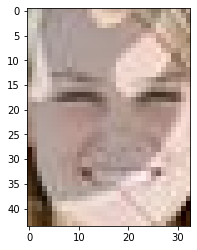

In [6]:
from tqdm import tqdm_notebook
for i in tqdm_notebook(range(3521, len(imtrain))):
    try:
        predict_images(imtrain[i])
    except ValueError:
        print(imtrain[i])

C:\Users\ilya_\Anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


GroupCohesion/val\pos_1681.jpg
GroupCohesion/val\pos_432.jpg



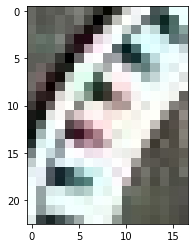

In [11]:
from tqdm import tqdm_notebook
for i in tqdm_notebook(range(2812,len(imval))):
    try:
        predict_val_images(imval[i])
    except ValueError:
        print(imval[i])

## Feature extraction

In [2]:
from keras_vggface.vggface import VGGFace
from keras.engine import Model
layers={'vgg16':'fc7/relu','resnet50':'avg_pool'}
model = VGGFace(model='resnet50')
out = model.get_layer(layers['resnet50']).output
cnn_model = Model(model.input, out)
_,w,h,_=model.input.shape
size=(int(w),int(h))

def extract_features(image_path):
    from keras_vggface.utils import preprocess_input
    from keras.preprocessing import image
    img = image.load_img(image_path, target_size=size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x, version=2)
    preds = cnn_model.predict(x).reshape(-1)
    return preds

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [7]:
det = glob.glob('detected/*')
len(det)

9257

In [8]:
dd = pd.read_pickle('detected_train.pickle')
dd

,img,filename
0,"[[1.5254766, 11.141492, 0.4482976, 0.0, 0.0, 2...",detected\neg_1
1,[],detected\neg_10
2,"[[0.0, 0.16655043, 0.0, 0.0, 0.06338836, 0.0, ...",detected\neg_1000
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",detected\neg_1001
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",detected\neg_1002
...,...,...
9252,"[[0.09674752, 0.038381733, 0.63436383, 0.16864...",detected\pos_995
9253,"[[0.0, 0.025460957, 4.6122084, 0.029441172, 0....",detected\pos_996
9254,"[[0.0, 0.0, 3.762611, 1.9277756, 0.55275196, 0...",detected\pos_997
9255,"[[2.310423, 2.11142, 0.9781727, 0.07706344, 0....",detected\pos_998


In [9]:
from tqdm import tqdm_notebook
import numpy as np
import pickle
detected = pd.read_pickle('detected_train.pickle')
for i in tqdm_notebook(range(4012,len(det))):
    ims = glob.glob(det[i]+'/*.jpg')
    lis = list()
    for imag in ims:
        feat = extract_features(imag)
        lis.append(feat)
    detected.loc[i] = [lis, det[i]]
    
with open('detected_train.pickle', 'wb') as f:
    pickle.dump(detected, f)

C:\Users\ilya_\Anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [9]:
det_val = glob.glob('detected_val/*')
len(det_val)

4216

In [10]:
from tqdm import tqdm_notebook
import numpy as np
import pickle
detected_val = pd.DataFrame(columns={'img', 'filename'})
for i in tqdm_notebook(range(len(det_val))):
    ims = glob.glob(det_val[i]+'/*.jpg')
    lis = list()
    for imag in ims:
        feat = extract_features(imag)
        lis.append(feat)
    detected_val.loc[i] = [lis, det_val[i]]


with open('detected_val.pickle', 'wb') as f:
    pickle.dump(detected_val, f)

C:\Users\ilya_\Anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


## Modeling

#### Some preprocessing

In [3]:
train = pd.read_pickle('detected_train.pickle')
train.head()

,img,filename
0,"[[1.5254766, 11.141492, 0.4482976, 0.0, 0.0, 2...",detected\neg_1
1,[],detected\neg_10
2,"[[0.0, 0.16655043, 0.0, 0.0, 0.06338836, 0.0, ...",detected\neg_1000
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",detected\neg_1001
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",detected\neg_1002


In [4]:
import warnings
warnings.filterwarnings('ignore')
train['feat'] = [np.mean(x, axis=0) for x in train['img']]
train.drop('img', axis=1, inplace=True)
train.dropna(inplace=True)
train['filename'] = train['filename'].apply(lambda x: x.split("detected")[1][1:])
labels = pd.read_csv('train.txt', header=None, sep='  ')
labels[0] = labels[0].apply(lambda x: x.split('.')[0])
train = pd.merge(train, labels, how='inner', left_on='filename', right_on=0)
train = train.rename(columns={0: 'name', 1: "target"})
for i in range(2048):
    train[i] = [x[i] for x in train['feat']]
train.drop(['name', 'feat'], axis=1, inplace=True)
train['emotion'] = list(map(lambda x: x.split('_')[0], train['filename']))
train['emotion'] = train['emotion'].apply(lambda x: (0 if x == 'neg' else (1 if x == 'neu' else (2 if x == 'pos' else x))))
train

,filename,target,0,1,2,3,4,5,6,7,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,emotion
0,neg_1,3,0.460677,3.638394,0.434650,0.000000,0.576307,0.616645,0.559138,1.416088,...,0.038617,0.975132,0.066808,0.327419,1.587912,0.221534,0.951750,1.041206,0.047075,0
1,neg_1000,3,0.000000,0.587027,2.190663,0.054587,0.226851,1.310902,1.229631,0.777825,...,0.543352,2.194074,0.103793,0.000000,0.924361,0.203494,0.092106,0.432779,1.288765,0
2,neg_1001,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.001410,0.000000,0.000000,...,1.152157,0.000000,0.000000,1.173056,0.198818,0.045570,0.000000,0.000000,0.000172,0
3,neg_1002,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.414712,0.013777,0.000000,0.225096,0.694502,0.000000,0.000000,0.000000,0.000000,0
4,neg_1003,3,0.160342,0.404085,2.546993,0.034746,1.233118,0.000000,0.075307,0.174687,...,0.019471,0.475554,0.995765,1.984174,4.824972,0.110051,0.014450,2.702672,0.075014,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9155,pos_995,2,0.439083,0.195205,1.370995,2.621298,3.217298,1.722276,1.389774,0.000000,...,0.040888,0.679291,0.290448,0.485724,0.429660,2.593271,1.032374,1.418264,0.650454,2
9156,pos_996,2,0.000000,0.471636,4.136220,0.067591,0.012043,0.723335,0.056688,0.091218,...,0.063188,0.707599,0.012222,1.210645,1.646341,1.544573,1.074116,0.737801,0.683695,2
9157,pos_997,2,0.557578,1.295933,1.156588,0.642281,0.225023,1.361395,1.991406,2.086457,...,0.819451,1.009925,1.719097,0.819543,0.329473,0.956742,3.351085,2.585369,0.727742,2
9158,pos_998,2,4.894585,1.359146,0.489086,0.050090,0.000000,0.758087,0.938868,0.000000,...,0.382864,0.199877,0.044113,0.891060,0.114697,1.293036,0.352355,0.102932,0.404432,2


In [4]:
import pickle
with open('train.pickle', 'wb') as f:
    pickle.dump(train, f)

In [5]:
val = pd.read_pickle('detected_val.pickle')
val['feat'] = [np.mean(x, axis=0) for x in val['filename']]
val.drop('filename', axis=1, inplace=True)
val.dropna(inplace=True)
val['img'] = val['img'].apply(lambda x: x.split('detected_val')[1][1:])
labels_val = pd.read_csv('validation.txt', header=None, sep='  ')
labels_val[0] = labels_val[0].apply(lambda x: x.split('.')[0])
val = pd.merge(val, labels_val, how='inner', left_on='img', right_on=0)
val = val.rename(columns={0: 'name', 1: "target"})
for i in range(2048):
    val[i] = [x[i] for x in val['feat']]
val.drop(['name', 'feat'], axis=1, inplace=True)
# with open('val.pickle', 'wb') as f:
#     pickle.dump(val, f)
val = val.rename(columns={'img':'filename'})
val['emotion'] = list(map(lambda x: x.split('_')[0], val['filename']))
val['emotion'] = val['emotion'].apply(lambda x: (0 if x == 'neg' else (1 if x == 'neu' else (2 if x == 'pos' else x))))
val

,filename,target,0,1,2,3,4,5,6,7,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,emotion
0,neg_1,2,2.040109,0.262198,2.539618,2.118542,0.294001,0.561279,0.644831,0.736722,...,0.134123,0.182421,1.250772,0.572287,2.514217,0.106363,0.759767,0.810378,0.156940,0
1,neg_10,0,0.330735,0.220028,0.421795,1.396341,0.169996,2.069834,0.293327,0.949459,...,0.715283,1.801324,1.408645,0.274550,2.418101,0.789999,0.292320,0.546722,0.858900,0
2,neg_1000,1,0.928810,0.763178,1.081553,0.247883,0.195344,0.926640,0.308249,0.731481,...,0.581830,1.587404,1.425795,0.625439,3.236256,0.121750,0.708526,0.059633,0.205143,0
3,neg_1001,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.709228,0.020886,0.001874,...,0.000000,0.745586,0.000000,0.000000,0.284642,0.000000,0.000000,0.000000,0.000000,0
4,neg_1002,1,0.136009,0.593313,2.678251,0.000281,0.000000,2.054854,1.174901,0.083203,...,0.904779,1.766557,0.877887,1.642305,2.249781,0.000000,1.049080,0.000000,0.421321,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4148,pos_995,3,0.053056,0.291673,1.509814,0.132548,0.889300,0.728793,1.393237,0.039593,...,3.350364,2.259472,1.012645,0.234941,0.748727,1.250264,0.638166,0.100788,1.112379,2
4149,pos_996,3,0.038617,0.437799,0.528441,0.439590,0.850128,1.044341,0.074159,0.501730,...,0.180360,0.131887,0.767427,0.228297,1.795712,0.817119,0.000000,0.056632,0.415531,2
4150,pos_997,3,0.190141,0.115894,0.580746,0.199075,0.070734,0.277128,0.414710,0.088367,...,0.406807,0.008889,0.169304,1.851103,0.454979,0.186428,0.261652,0.067151,0.150449,2
4151,pos_998,3,0.668653,1.294021,0.502810,0.505544,0.201286,3.691780,0.372581,2.067420,...,2.240234,2.976504,3.603006,0.192416,2.394370,0.639194,3.126710,0.023644,0.281983,2


In [6]:
train['target'].value_counts()

2    4528
3    1966
1    1541
0    1125
Name: target, dtype: int64

In [7]:
train['emotion'].value_counts()

2    3808
1    2926
0    2426
Name: emotion, dtype: int64

In [8]:
train.drop('emotion', axis=1, inplace=True)
val.drop('emotion', axis=1, inplace=True)

### Catboost

In [9]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(depth=3, n_estimators=10000, learning_rate=0.01, loss_function='MultiClass')
cb.fit(train.drop(['filename', 'target'], axis=1), train['target'])

0:	learn: 1.3824263	total: 393ms	remaining: 1h 5m 27s
1:	learn: 1.3789022	total: 656ms	remaining: 54m 39s
2:	learn: 1.3753949	total: 896ms	remaining: 49m 44s
3:	learn: 1.3716630	total: 1.15s	remaining: 48m 4s
4:	learn: 1.3682217	total: 1.43s	remaining: 47m 48s
5:	learn: 1.3647312	total: 1.69s	remaining: 46m 49s
6:	learn: 1.3611651	total: 1.93s	remaining: 45m 59s
7:	learn: 1.3577662	total: 2.18s	remaining: 45m 23s
8:	learn: 1.3544711	total: 2.44s	remaining: 45m 10s
9:	learn: 1.3515829	total: 2.71s	remaining: 45m 8s
10:	learn: 1.3488356	total: 2.95s	remaining: 44m 37s
11:	learn: 1.3460111	total: 3.21s	remaining: 44m 30s
12:	learn: 1.3428801	total: 3.46s	remaining: 44m 16s
13:	learn: 1.3399078	total: 3.74s	remaining: 44m 25s
14:	learn: 1.3371469	total: 3.98s	remaining: 44m 12s
15:	learn: 1.3347335	total: 4.25s	remaining: 44m 13s
16:	learn: 1.3322412	total: 4.5s	remaining: 44m 3s
17:	learn: 1.3298246	total: 4.79s	remaining: 44m 19s
18:	learn: 1.3275209	total: 5.03s	remaining: 44m 2s
19:	le

155:	learn: 1.1833643	total: 36.6s	remaining: 38m 30s
156:	learn: 1.1827819	total: 36.8s	remaining: 38m 29s
157:	learn: 1.1822680	total: 37s	remaining: 38m 26s
158:	learn: 1.1819509	total: 37.2s	remaining: 38m 23s
159:	learn: 1.1816068	total: 37.4s	remaining: 38m 20s
160:	learn: 1.1813022	total: 37.6s	remaining: 38m 18s
161:	learn: 1.1808150	total: 37.8s	remaining: 38m 14s
162:	learn: 1.1804155	total: 38s	remaining: 38m 12s
163:	learn: 1.1801068	total: 38.2s	remaining: 38m 8s
164:	learn: 1.1796678	total: 38.4s	remaining: 38m 7s
165:	learn: 1.1791859	total: 38.6s	remaining: 38m 6s
166:	learn: 1.1788433	total: 38.8s	remaining: 38m 6s
167:	learn: 1.1785226	total: 39.1s	remaining: 38m 5s
168:	learn: 1.1780763	total: 39.3s	remaining: 38m 6s
169:	learn: 1.1776829	total: 39.5s	remaining: 38m 4s
170:	learn: 1.1773367	total: 39.7s	remaining: 38m 4s
171:	learn: 1.1770290	total: 40s	remaining: 38m 4s
172:	learn: 1.1767825	total: 40.2s	remaining: 38m 1s
173:	learn: 1.1764672	total: 40.4s	remaining

308:	learn: 1.1434955	total: 1m 11s	remaining: 37m 16s
309:	learn: 1.1432298	total: 1m 11s	remaining: 37m 16s
310:	learn: 1.1430779	total: 1m 11s	remaining: 37m 17s
311:	learn: 1.1429008	total: 1m 12s	remaining: 37m 17s
312:	learn: 1.1427119	total: 1m 12s	remaining: 37m 17s
313:	learn: 1.1425823	total: 1m 12s	remaining: 37m 18s
314:	learn: 1.1424478	total: 1m 12s	remaining: 37m 18s
315:	learn: 1.1422668	total: 1m 13s	remaining: 37m 18s
316:	learn: 1.1420487	total: 1m 13s	remaining: 37m 18s
317:	learn: 1.1419173	total: 1m 13s	remaining: 37m 17s
318:	learn: 1.1417570	total: 1m 13s	remaining: 37m 17s
319:	learn: 1.1416396	total: 1m 13s	remaining: 37m 15s
320:	learn: 1.1415323	total: 1m 14s	remaining: 37m 13s
321:	learn: 1.1413664	total: 1m 14s	remaining: 37m 11s
322:	learn: 1.1412587	total: 1m 14s	remaining: 37m 9s
323:	learn: 1.1411906	total: 1m 14s	remaining: 37m 7s
324:	learn: 1.1410448	total: 1m 14s	remaining: 37m 6s
325:	learn: 1.1409677	total: 1m 15s	remaining: 37m 6s
326:	learn: 1.

458:	learn: 1.1237520	total: 1m 39s	remaining: 34m 20s
459:	learn: 1.1236531	total: 1m 39s	remaining: 34m 19s
460:	learn: 1.1235474	total: 1m 39s	remaining: 34m 18s
461:	learn: 1.1234533	total: 1m 39s	remaining: 34m 17s
462:	learn: 1.1233500	total: 1m 39s	remaining: 34m 16s
463:	learn: 1.1232955	total: 1m 40s	remaining: 34m 15s
464:	learn: 1.1231388	total: 1m 40s	remaining: 34m 14s
465:	learn: 1.1229822	total: 1m 40s	remaining: 34m 12s
466:	learn: 1.1228404	total: 1m 40s	remaining: 34m 11s
467:	learn: 1.1227128	total: 1m 40s	remaining: 34m 10s
468:	learn: 1.1226020	total: 1m 40s	remaining: 34m 10s
469:	learn: 1.1224933	total: 1m 41s	remaining: 34m 10s
470:	learn: 1.1223420	total: 1m 41s	remaining: 34m 8s
471:	learn: 1.1222098	total: 1m 41s	remaining: 34m 7s
472:	learn: 1.1221529	total: 1m 41s	remaining: 34m 6s
473:	learn: 1.1220234	total: 1m 41s	remaining: 34m 5s
474:	learn: 1.1219113	total: 1m 41s	remaining: 34m 4s
475:	learn: 1.1217750	total: 1m 42s	remaining: 34m 4s
476:	learn: 1.12

610:	learn: 1.1087895	total: 2m 6s	remaining: 32m 31s
611:	learn: 1.1087226	total: 2m 7s	remaining: 32m 30s
612:	learn: 1.1086519	total: 2m 7s	remaining: 32m 30s
613:	learn: 1.1085551	total: 2m 7s	remaining: 32m 29s
614:	learn: 1.1085039	total: 2m 7s	remaining: 32m 28s
615:	learn: 1.1084024	total: 2m 7s	remaining: 32m 28s
616:	learn: 1.1082596	total: 2m 8s	remaining: 32m 28s
617:	learn: 1.1081595	total: 2m 8s	remaining: 32m 28s
618:	learn: 1.1080792	total: 2m 8s	remaining: 32m 27s
619:	learn: 1.1079654	total: 2m 8s	remaining: 32m 26s
620:	learn: 1.1078875	total: 2m 8s	remaining: 32m 26s
621:	learn: 1.1077747	total: 2m 9s	remaining: 32m 26s
622:	learn: 1.1076638	total: 2m 9s	remaining: 32m 26s
623:	learn: 1.1075852	total: 2m 9s	remaining: 32m 26s
624:	learn: 1.1075162	total: 2m 9s	remaining: 32m 25s
625:	learn: 1.1074666	total: 2m 9s	remaining: 32m 25s
626:	learn: 1.1073794	total: 2m 10s	remaining: 32m 24s
627:	learn: 1.1072948	total: 2m 10s	remaining: 32m 24s
628:	learn: 1.1071639	tota

760:	learn: 1.0962280	total: 2m 35s	remaining: 31m 25s
761:	learn: 1.0961297	total: 2m 35s	remaining: 31m 25s
762:	learn: 1.0960450	total: 2m 35s	remaining: 31m 24s
763:	learn: 1.0959661	total: 2m 35s	remaining: 31m 24s
764:	learn: 1.0958973	total: 2m 36s	remaining: 31m 24s
765:	learn: 1.0958314	total: 2m 36s	remaining: 31m 23s
766:	learn: 1.0957511	total: 2m 36s	remaining: 31m 22s
767:	learn: 1.0956763	total: 2m 36s	remaining: 31m 22s
768:	learn: 1.0956249	total: 2m 36s	remaining: 31m 22s
769:	learn: 1.0955840	total: 2m 36s	remaining: 31m 21s
770:	learn: 1.0955146	total: 2m 37s	remaining: 31m 21s
771:	learn: 1.0954313	total: 2m 37s	remaining: 31m 20s
772:	learn: 1.0953681	total: 2m 37s	remaining: 31m 20s
773:	learn: 1.0952953	total: 2m 37s	remaining: 31m 19s
774:	learn: 1.0951936	total: 2m 37s	remaining: 31m 19s
775:	learn: 1.0950977	total: 2m 38s	remaining: 31m 18s
776:	learn: 1.0950393	total: 2m 38s	remaining: 31m 18s
777:	learn: 1.0949527	total: 2m 38s	remaining: 31m 18s
778:	learn

912:	learn: 1.0850291	total: 3m 3s	remaining: 30m 24s
913:	learn: 1.0849454	total: 3m 3s	remaining: 30m 24s
914:	learn: 1.0849018	total: 3m 3s	remaining: 30m 23s
915:	learn: 1.0848395	total: 3m 3s	remaining: 30m 23s
916:	learn: 1.0847654	total: 3m 4s	remaining: 30m 23s
917:	learn: 1.0847159	total: 3m 4s	remaining: 30m 22s
918:	learn: 1.0845973	total: 3m 4s	remaining: 30m 22s
919:	learn: 1.0845291	total: 3m 4s	remaining: 30m 22s
920:	learn: 1.0844689	total: 3m 4s	remaining: 30m 21s
921:	learn: 1.0843545	total: 3m 4s	remaining: 30m 21s
922:	learn: 1.0842914	total: 3m 5s	remaining: 30m 21s
923:	learn: 1.0842155	total: 3m 5s	remaining: 30m 21s
924:	learn: 1.0841504	total: 3m 5s	remaining: 30m 20s
925:	learn: 1.0840426	total: 3m 5s	remaining: 30m 20s
926:	learn: 1.0839751	total: 3m 5s	remaining: 30m 19s
927:	learn: 1.0838755	total: 3m 6s	remaining: 30m 19s
928:	learn: 1.0837789	total: 3m 6s	remaining: 30m 19s
929:	learn: 1.0837248	total: 3m 6s	remaining: 30m 18s
930:	learn: 1.0836578	total:

1062:	learn: 1.0732840	total: 3m 34s	remaining: 30m 1s
1063:	learn: 1.0731779	total: 3m 34s	remaining: 30m 2s
1064:	learn: 1.0730923	total: 3m 34s	remaining: 30m 3s
1065:	learn: 1.0730112	total: 3m 35s	remaining: 30m 3s
1066:	learn: 1.0729479	total: 3m 35s	remaining: 30m 4s
1067:	learn: 1.0728689	total: 3m 35s	remaining: 30m 4s
1068:	learn: 1.0727920	total: 3m 36s	remaining: 30m 5s
1069:	learn: 1.0727100	total: 3m 36s	remaining: 30m 6s
1070:	learn: 1.0726478	total: 3m 36s	remaining: 30m 6s
1071:	learn: 1.0725818	total: 3m 37s	remaining: 30m 7s
1072:	learn: 1.0725040	total: 3m 37s	remaining: 30m 7s
1073:	learn: 1.0724184	total: 3m 37s	remaining: 30m 8s
1074:	learn: 1.0723176	total: 3m 37s	remaining: 30m 9s
1075:	learn: 1.0722049	total: 3m 38s	remaining: 30m 9s
1076:	learn: 1.0721222	total: 3m 38s	remaining: 30m 10s
1077:	learn: 1.0720366	total: 3m 38s	remaining: 30m 11s
1078:	learn: 1.0719288	total: 3m 39s	remaining: 30m 11s
1079:	learn: 1.0718916	total: 3m 39s	remaining: 30m 12s
1080:	

1210:	learn: 1.0626421	total: 4m 10s	remaining: 30m 18s
1211:	learn: 1.0625970	total: 4m 10s	remaining: 30m 18s
1212:	learn: 1.0625212	total: 4m 10s	remaining: 30m 17s
1213:	learn: 1.0624454	total: 4m 11s	remaining: 30m 17s
1214:	learn: 1.0623915	total: 4m 11s	remaining: 30m 17s
1215:	learn: 1.0623064	total: 4m 11s	remaining: 30m 16s
1216:	learn: 1.0622358	total: 4m 11s	remaining: 30m 16s
1217:	learn: 1.0621929	total: 4m 11s	remaining: 30m 15s
1218:	learn: 1.0621171	total: 4m 12s	remaining: 30m 15s
1219:	learn: 1.0620499	total: 4m 12s	remaining: 30m 14s
1220:	learn: 1.0619822	total: 4m 12s	remaining: 30m 14s
1221:	learn: 1.0619229	total: 4m 12s	remaining: 30m 14s
1222:	learn: 1.0618225	total: 4m 12s	remaining: 30m 13s
1223:	learn: 1.0617618	total: 4m 12s	remaining: 30m 13s
1224:	learn: 1.0616804	total: 4m 13s	remaining: 30m 12s
1225:	learn: 1.0616007	total: 4m 13s	remaining: 30m 12s
1226:	learn: 1.0615537	total: 4m 13s	remaining: 30m 11s
1227:	learn: 1.0614769	total: 4m 13s	remaining: 

1357:	learn: 1.0524295	total: 4m 37s	remaining: 29m 23s
1358:	learn: 1.0523464	total: 4m 37s	remaining: 29m 23s
1359:	learn: 1.0523046	total: 4m 37s	remaining: 29m 22s
1360:	learn: 1.0521945	total: 4m 37s	remaining: 29m 22s
1361:	learn: 1.0521364	total: 4m 37s	remaining: 29m 22s
1362:	learn: 1.0520786	total: 4m 38s	remaining: 29m 21s
1363:	learn: 1.0520192	total: 4m 38s	remaining: 29m 21s
1364:	learn: 1.0519297	total: 4m 38s	remaining: 29m 21s
1365:	learn: 1.0518517	total: 4m 38s	remaining: 29m 20s
1366:	learn: 1.0517731	total: 4m 38s	remaining: 29m 20s
1367:	learn: 1.0517085	total: 4m 38s	remaining: 29m 20s
1368:	learn: 1.0516616	total: 4m 39s	remaining: 29m 19s
1369:	learn: 1.0516127	total: 4m 39s	remaining: 29m 19s
1370:	learn: 1.0515269	total: 4m 39s	remaining: 29m 18s
1371:	learn: 1.0514374	total: 4m 39s	remaining: 29m 18s
1372:	learn: 1.0513482	total: 4m 39s	remaining: 29m 17s
1373:	learn: 1.0512751	total: 4m 39s	remaining: 29m 17s
1374:	learn: 1.0511840	total: 4m 40s	remaining: 

1505:	learn: 1.0427590	total: 5m 7s	remaining: 28m 56s
1506:	learn: 1.0427198	total: 5m 8s	remaining: 28m 55s
1507:	learn: 1.0426450	total: 5m 8s	remaining: 28m 55s
1508:	learn: 1.0425851	total: 5m 8s	remaining: 28m 55s
1509:	learn: 1.0425345	total: 5m 8s	remaining: 28m 55s
1510:	learn: 1.0424715	total: 5m 8s	remaining: 28m 55s
1511:	learn: 1.0424040	total: 5m 9s	remaining: 28m 55s
1512:	learn: 1.0423542	total: 5m 9s	remaining: 28m 54s
1513:	learn: 1.0422955	total: 5m 9s	remaining: 28m 54s
1514:	learn: 1.0422113	total: 5m 9s	remaining: 28m 54s
1515:	learn: 1.0421616	total: 5m 9s	remaining: 28m 54s
1516:	learn: 1.0421000	total: 5m 10s	remaining: 28m 54s
1517:	learn: 1.0420299	total: 5m 10s	remaining: 28m 54s
1518:	learn: 1.0419720	total: 5m 10s	remaining: 28m 54s
1519:	learn: 1.0419174	total: 5m 10s	remaining: 28m 54s
1520:	learn: 1.0418362	total: 5m 11s	remaining: 28m 54s
1521:	learn: 1.0417857	total: 5m 11s	remaining: 28m 54s
1522:	learn: 1.0417191	total: 5m 11s	remaining: 28m 54s
152

1652:	learn: 1.0337448	total: 5m 37s	remaining: 28m 23s
1653:	learn: 1.0336960	total: 5m 37s	remaining: 28m 24s
1654:	learn: 1.0336215	total: 5m 37s	remaining: 28m 23s
1655:	learn: 1.0335558	total: 5m 38s	remaining: 28m 24s
1656:	learn: 1.0334736	total: 5m 38s	remaining: 28m 23s
1657:	learn: 1.0334342	total: 5m 38s	remaining: 28m 23s
1658:	learn: 1.0333925	total: 5m 38s	remaining: 28m 23s
1659:	learn: 1.0333468	total: 5m 39s	remaining: 28m 23s
1660:	learn: 1.0332934	total: 5m 39s	remaining: 28m 23s
1661:	learn: 1.0332191	total: 5m 39s	remaining: 28m 22s
1662:	learn: 1.0331434	total: 5m 39s	remaining: 28m 22s
1663:	learn: 1.0330800	total: 5m 39s	remaining: 28m 21s
1664:	learn: 1.0330103	total: 5m 39s	remaining: 28m 21s
1665:	learn: 1.0329368	total: 5m 40s	remaining: 28m 21s
1666:	learn: 1.0328853	total: 5m 40s	remaining: 28m 20s
1667:	learn: 1.0328279	total: 5m 40s	remaining: 28m 20s
1668:	learn: 1.0327410	total: 5m 40s	remaining: 28m 20s
1669:	learn: 1.0326608	total: 5m 40s	remaining: 

1800:	learn: 1.0249760	total: 6m 11s	remaining: 28m 12s
1801:	learn: 1.0249250	total: 6m 12s	remaining: 28m 12s
1802:	learn: 1.0248848	total: 6m 12s	remaining: 28m 12s
1803:	learn: 1.0248338	total: 6m 12s	remaining: 28m 12s
1804:	learn: 1.0247446	total: 6m 12s	remaining: 28m 12s
1805:	learn: 1.0246888	total: 6m 13s	remaining: 28m 12s
1806:	learn: 1.0246300	total: 6m 13s	remaining: 28m 12s
1807:	learn: 1.0245606	total: 6m 13s	remaining: 28m 12s
1808:	learn: 1.0245137	total: 6m 13s	remaining: 28m 12s
1809:	learn: 1.0244543	total: 6m 14s	remaining: 28m 12s
1810:	learn: 1.0243989	total: 6m 14s	remaining: 28m 12s
1811:	learn: 1.0243265	total: 6m 14s	remaining: 28m 12s
1812:	learn: 1.0242557	total: 6m 14s	remaining: 28m 12s
1813:	learn: 1.0242040	total: 6m 14s	remaining: 28m 12s
1814:	learn: 1.0241430	total: 6m 15s	remaining: 28m 12s
1815:	learn: 1.0240947	total: 6m 15s	remaining: 28m 12s
1816:	learn: 1.0240414	total: 6m 15s	remaining: 28m 12s
1817:	learn: 1.0239950	total: 6m 16s	remaining: 

1948:	learn: 1.0167838	total: 6m 41s	remaining: 27m 39s
1949:	learn: 1.0167214	total: 6m 41s	remaining: 27m 38s
1950:	learn: 1.0166668	total: 6m 41s	remaining: 27m 38s
1951:	learn: 1.0165909	total: 6m 42s	remaining: 27m 37s
1952:	learn: 1.0165290	total: 6m 42s	remaining: 27m 37s
1953:	learn: 1.0164483	total: 6m 42s	remaining: 27m 37s
1954:	learn: 1.0163826	total: 6m 42s	remaining: 27m 36s
1955:	learn: 1.0163241	total: 6m 42s	remaining: 27m 36s
1956:	learn: 1.0162537	total: 6m 42s	remaining: 27m 36s
1957:	learn: 1.0161961	total: 6m 43s	remaining: 27m 35s
1958:	learn: 1.0161392	total: 6m 43s	remaining: 27m 35s
1959:	learn: 1.0160870	total: 6m 43s	remaining: 27m 35s
1960:	learn: 1.0160146	total: 6m 43s	remaining: 27m 34s
1961:	learn: 1.0159350	total: 6m 43s	remaining: 27m 34s
1962:	learn: 1.0158848	total: 6m 43s	remaining: 27m 33s
1963:	learn: 1.0158084	total: 6m 44s	remaining: 27m 33s
1964:	learn: 1.0157594	total: 6m 44s	remaining: 27m 33s
1965:	learn: 1.0157217	total: 6m 44s	remaining: 

2097:	learn: 1.0088952	total: 7m 7s	remaining: 26m 49s
2098:	learn: 1.0088513	total: 7m 7s	remaining: 26m 49s
2099:	learn: 1.0088253	total: 7m 7s	remaining: 26m 49s
2100:	learn: 1.0087897	total: 7m 7s	remaining: 26m 48s
2101:	learn: 1.0087428	total: 7m 8s	remaining: 26m 48s
2102:	learn: 1.0086966	total: 7m 8s	remaining: 26m 48s
2103:	learn: 1.0086565	total: 7m 8s	remaining: 26m 48s
2104:	learn: 1.0086187	total: 7m 8s	remaining: 26m 47s
2105:	learn: 1.0085596	total: 7m 8s	remaining: 26m 47s
2106:	learn: 1.0085173	total: 7m 8s	remaining: 26m 47s
2107:	learn: 1.0084632	total: 7m 9s	remaining: 26m 46s
2108:	learn: 1.0084095	total: 7m 9s	remaining: 26m 46s
2109:	learn: 1.0083458	total: 7m 9s	remaining: 26m 46s
2110:	learn: 1.0083013	total: 7m 9s	remaining: 26m 45s
2111:	learn: 1.0082517	total: 7m 9s	remaining: 26m 45s
2112:	learn: 1.0081896	total: 7m 10s	remaining: 26m 45s
2113:	learn: 1.0081325	total: 7m 10s	remaining: 26m 44s
2114:	learn: 1.0080648	total: 7m 10s	remaining: 26m 44s
2115:	l

2244:	learn: 1.0013957	total: 7m 33s	remaining: 26m 8s
2245:	learn: 1.0013525	total: 7m 34s	remaining: 26m 7s
2246:	learn: 1.0013170	total: 7m 34s	remaining: 26m 7s
2247:	learn: 1.0012637	total: 7m 34s	remaining: 26m 7s
2248:	learn: 1.0012103	total: 7m 34s	remaining: 26m 6s
2249:	learn: 1.0011544	total: 7m 34s	remaining: 26m 6s
2250:	learn: 1.0010991	total: 7m 34s	remaining: 26m 6s
2251:	learn: 1.0010428	total: 7m 35s	remaining: 26m 6s
2252:	learn: 1.0010010	total: 7m 35s	remaining: 26m 5s
2253:	learn: 1.0009493	total: 7m 35s	remaining: 26m 5s
2254:	learn: 1.0009034	total: 7m 35s	remaining: 26m 5s
2255:	learn: 1.0008549	total: 7m 35s	remaining: 26m 4s
2256:	learn: 1.0008234	total: 7m 36s	remaining: 26m 4s
2257:	learn: 1.0007736	total: 7m 36s	remaining: 26m 4s
2258:	learn: 1.0007360	total: 7m 36s	remaining: 26m 4s
2259:	learn: 1.0006967	total: 7m 36s	remaining: 26m 3s
2260:	learn: 1.0006218	total: 7m 36s	remaining: 26m 3s
2261:	learn: 1.0005731	total: 7m 37s	remaining: 26m 3s
2262:	lear

2392:	learn: 0.9942007	total: 8m	remaining: 25m 28s
2393:	learn: 0.9941433	total: 8m	remaining: 25m 27s
2394:	learn: 0.9940548	total: 8m 1s	remaining: 25m 27s
2395:	learn: 0.9939988	total: 8m 1s	remaining: 25m 27s
2396:	learn: 0.9939544	total: 8m 1s	remaining: 25m 27s
2397:	learn: 0.9939071	total: 8m 1s	remaining: 25m 26s
2398:	learn: 0.9938741	total: 8m 1s	remaining: 25m 26s
2399:	learn: 0.9938293	total: 8m 2s	remaining: 25m 26s
2400:	learn: 0.9937641	total: 8m 2s	remaining: 25m 26s
2401:	learn: 0.9937175	total: 8m 2s	remaining: 25m 25s
2402:	learn: 0.9936717	total: 8m 2s	remaining: 25m 25s
2403:	learn: 0.9936345	total: 8m 2s	remaining: 25m 25s
2404:	learn: 0.9935732	total: 8m 2s	remaining: 25m 24s
2405:	learn: 0.9935366	total: 8m 3s	remaining: 25m 24s
2406:	learn: 0.9934904	total: 8m 3s	remaining: 25m 24s
2407:	learn: 0.9934570	total: 8m 3s	remaining: 25m 24s
2408:	learn: 0.9934209	total: 8m 3s	remaining: 25m 23s
2409:	learn: 0.9933845	total: 8m 3s	remaining: 25m 23s
2410:	learn: 0.9

2542:	learn: 0.9869457	total: 8m 28s	remaining: 24m 49s
2543:	learn: 0.9868949	total: 8m 28s	remaining: 24m 49s
2544:	learn: 0.9868498	total: 8m 28s	remaining: 24m 49s
2545:	learn: 0.9868149	total: 8m 28s	remaining: 24m 49s
2546:	learn: 0.9867590	total: 8m 28s	remaining: 24m 48s
2547:	learn: 0.9867134	total: 8m 29s	remaining: 24m 48s
2548:	learn: 0.9866696	total: 8m 29s	remaining: 24m 48s
2549:	learn: 0.9866429	total: 8m 29s	remaining: 24m 48s
2550:	learn: 0.9865796	total: 8m 29s	remaining: 24m 47s
2551:	learn: 0.9865320	total: 8m 29s	remaining: 24m 47s
2552:	learn: 0.9864913	total: 8m 29s	remaining: 24m 47s
2553:	learn: 0.9864529	total: 8m 30s	remaining: 24m 47s
2554:	learn: 0.9864086	total: 8m 30s	remaining: 24m 46s
2555:	learn: 0.9863525	total: 8m 30s	remaining: 24m 46s
2556:	learn: 0.9863106	total: 8m 30s	remaining: 24m 46s
2557:	learn: 0.9862500	total: 8m 30s	remaining: 24m 46s
2558:	learn: 0.9862137	total: 8m 30s	remaining: 24m 45s
2559:	learn: 0.9861802	total: 8m 31s	remaining: 

2690:	learn: 0.9799441	total: 8m 54s	remaining: 24m 12s
2691:	learn: 0.9799057	total: 8m 55s	remaining: 24m 12s
2692:	learn: 0.9798512	total: 8m 55s	remaining: 24m 12s
2693:	learn: 0.9798139	total: 8m 55s	remaining: 24m 11s
2694:	learn: 0.9797688	total: 8m 55s	remaining: 24m 11s
2695:	learn: 0.9797311	total: 8m 55s	remaining: 24m 11s
2696:	learn: 0.9796767	total: 8m 55s	remaining: 24m 11s
2697:	learn: 0.9796336	total: 8m 56s	remaining: 24m 10s
2698:	learn: 0.9795863	total: 8m 56s	remaining: 24m 10s
2699:	learn: 0.9795244	total: 8m 56s	remaining: 24m 10s
2700:	learn: 0.9794830	total: 8m 56s	remaining: 24m 10s
2701:	learn: 0.9794401	total: 8m 56s	remaining: 24m 10s
2702:	learn: 0.9793908	total: 8m 57s	remaining: 24m 9s
2703:	learn: 0.9793425	total: 8m 57s	remaining: 24m 9s
2704:	learn: 0.9792984	total: 8m 57s	remaining: 24m 9s
2705:	learn: 0.9792616	total: 8m 57s	remaining: 24m 9s
2706:	learn: 0.9792205	total: 8m 57s	remaining: 24m 8s
2707:	learn: 0.9791461	total: 8m 57s	remaining: 24m 8

2839:	learn: 0.9730951	total: 9m 21s	remaining: 23m 36s
2840:	learn: 0.9730453	total: 9m 22s	remaining: 23m 36s
2841:	learn: 0.9729998	total: 9m 22s	remaining: 23m 35s
2842:	learn: 0.9729576	total: 9m 22s	remaining: 23m 35s
2843:	learn: 0.9728947	total: 9m 22s	remaining: 23m 35s
2844:	learn: 0.9728311	total: 9m 22s	remaining: 23m 35s
2845:	learn: 0.9727826	total: 9m 22s	remaining: 23m 34s
2846:	learn: 0.9727446	total: 9m 23s	remaining: 23m 34s
2847:	learn: 0.9727005	total: 9m 23s	remaining: 23m 34s
2848:	learn: 0.9726736	total: 9m 23s	remaining: 23m 34s
2849:	learn: 0.9726200	total: 9m 23s	remaining: 23m 34s
2850:	learn: 0.9725767	total: 9m 23s	remaining: 23m 33s
2851:	learn: 0.9725333	total: 9m 24s	remaining: 23m 33s
2852:	learn: 0.9724806	total: 9m 24s	remaining: 23m 33s
2853:	learn: 0.9724493	total: 9m 24s	remaining: 23m 33s
2854:	learn: 0.9724186	total: 9m 24s	remaining: 23m 32s
2855:	learn: 0.9723847	total: 9m 24s	remaining: 23m 32s
2856:	learn: 0.9723667	total: 9m 24s	remaining: 

2987:	learn: 0.9667761	total: 9m 48s	remaining: 23m 1s
2988:	learn: 0.9667334	total: 9m 48s	remaining: 23m
2989:	learn: 0.9667050	total: 9m 48s	remaining: 23m
2990:	learn: 0.9666432	total: 9m 49s	remaining: 23m
2991:	learn: 0.9666109	total: 9m 49s	remaining: 23m
2992:	learn: 0.9665765	total: 9m 49s	remaining: 22m 59s
2993:	learn: 0.9665466	total: 9m 49s	remaining: 22m 59s
2994:	learn: 0.9664987	total: 9m 49s	remaining: 22m 59s
2995:	learn: 0.9664545	total: 9m 49s	remaining: 22m 59s
2996:	learn: 0.9664071	total: 9m 50s	remaining: 22m 58s
2997:	learn: 0.9663781	total: 9m 50s	remaining: 22m 58s
2998:	learn: 0.9663478	total: 9m 50s	remaining: 22m 58s
2999:	learn: 0.9663223	total: 9m 50s	remaining: 22m 58s
3000:	learn: 0.9662701	total: 9m 50s	remaining: 22m 57s
3001:	learn: 0.9662089	total: 9m 51s	remaining: 22m 57s
3002:	learn: 0.9661758	total: 9m 51s	remaining: 22m 57s
3003:	learn: 0.9661332	total: 9m 51s	remaining: 22m 57s
3004:	learn: 0.9660784	total: 9m 51s	remaining: 22m 57s
3005:	lea

3134:	learn: 0.9604518	total: 10m 15s	remaining: 22m 26s
3135:	learn: 0.9604135	total: 10m 15s	remaining: 22m 26s
3136:	learn: 0.9603755	total: 10m 15s	remaining: 22m 26s
3137:	learn: 0.9603425	total: 10m 15s	remaining: 22m 26s
3138:	learn: 0.9603211	total: 10m 15s	remaining: 22m 25s
3139:	learn: 0.9602768	total: 10m 15s	remaining: 22m 25s
3140:	learn: 0.9602343	total: 10m 16s	remaining: 22m 25s
3141:	learn: 0.9601916	total: 10m 16s	remaining: 22m 25s
3142:	learn: 0.9601490	total: 10m 16s	remaining: 22m 24s
3143:	learn: 0.9600965	total: 10m 16s	remaining: 22m 24s
3144:	learn: 0.9600658	total: 10m 16s	remaining: 22m 24s
3145:	learn: 0.9600240	total: 10m 17s	remaining: 22m 24s
3146:	learn: 0.9600049	total: 10m 17s	remaining: 22m 23s
3147:	learn: 0.9599674	total: 10m 17s	remaining: 22m 23s
3148:	learn: 0.9599141	total: 10m 17s	remaining: 22m 23s
3149:	learn: 0.9598611	total: 10m 17s	remaining: 22m 23s
3150:	learn: 0.9598071	total: 10m 17s	remaining: 22m 23s
3151:	learn: 0.9597743	total: 1

3280:	learn: 0.9541648	total: 10m 41s	remaining: 21m 54s
3281:	learn: 0.9541208	total: 10m 41s	remaining: 21m 53s
3282:	learn: 0.9540823	total: 10m 42s	remaining: 21m 53s
3283:	learn: 0.9540206	total: 10m 42s	remaining: 21m 53s
3284:	learn: 0.9539934	total: 10m 42s	remaining: 21m 53s
3285:	learn: 0.9539489	total: 10m 42s	remaining: 21m 53s
3286:	learn: 0.9538932	total: 10m 42s	remaining: 21m 53s
3287:	learn: 0.9538439	total: 10m 43s	remaining: 21m 53s
3288:	learn: 0.9537894	total: 10m 43s	remaining: 21m 52s
3289:	learn: 0.9537487	total: 10m 43s	remaining: 21m 52s
3290:	learn: 0.9537133	total: 10m 43s	remaining: 21m 52s
3291:	learn: 0.9536649	total: 10m 44s	remaining: 21m 52s
3292:	learn: 0.9536360	total: 10m 44s	remaining: 21m 52s
3293:	learn: 0.9536137	total: 10m 44s	remaining: 21m 52s
3294:	learn: 0.9535731	total: 10m 44s	remaining: 21m 52s
3295:	learn: 0.9535281	total: 10m 45s	remaining: 21m 52s
3296:	learn: 0.9534924	total: 10m 45s	remaining: 21m 52s
3297:	learn: 0.9534478	total: 1

3425:	learn: 0.9480414	total: 11m 15s	remaining: 21m 35s
3426:	learn: 0.9480061	total: 11m 15s	remaining: 21m 35s
3427:	learn: 0.9479900	total: 11m 15s	remaining: 21m 35s
3428:	learn: 0.9479520	total: 11m 15s	remaining: 21m 34s
3429:	learn: 0.9478968	total: 11m 15s	remaining: 21m 34s
3430:	learn: 0.9478464	total: 11m 16s	remaining: 21m 34s
3431:	learn: 0.9477927	total: 11m 16s	remaining: 21m 34s
3432:	learn: 0.9477388	total: 11m 16s	remaining: 21m 34s
3433:	learn: 0.9476655	total: 11m 16s	remaining: 21m 34s
3434:	learn: 0.9476110	total: 11m 17s	remaining: 21m 34s
3435:	learn: 0.9475526	total: 11m 17s	remaining: 21m 34s
3436:	learn: 0.9475179	total: 11m 17s	remaining: 21m 34s
3437:	learn: 0.9474750	total: 11m 17s	remaining: 21m 33s
3438:	learn: 0.9474240	total: 11m 18s	remaining: 21m 33s
3439:	learn: 0.9473731	total: 11m 18s	remaining: 21m 33s
3440:	learn: 0.9473265	total: 11m 18s	remaining: 21m 33s
3441:	learn: 0.9472887	total: 11m 18s	remaining: 21m 33s
3442:	learn: 0.9472673	total: 1

3569:	learn: 0.9419365	total: 11m 48s	remaining: 21m 16s
3570:	learn: 0.9419021	total: 11m 48s	remaining: 21m 16s
3571:	learn: 0.9418573	total: 11m 48s	remaining: 21m 15s
3572:	learn: 0.9418216	total: 11m 49s	remaining: 21m 15s
3573:	learn: 0.9417890	total: 11m 49s	remaining: 21m 15s
3574:	learn: 0.9417410	total: 11m 49s	remaining: 21m 15s
3575:	learn: 0.9416968	total: 11m 49s	remaining: 21m 15s
3576:	learn: 0.9416554	total: 11m 50s	remaining: 21m 14s
3577:	learn: 0.9415980	total: 11m 50s	remaining: 21m 14s
3578:	learn: 0.9415695	total: 11m 50s	remaining: 21m 14s
3579:	learn: 0.9415354	total: 11m 50s	remaining: 21m 14s
3580:	learn: 0.9414820	total: 11m 50s	remaining: 21m 14s
3581:	learn: 0.9414534	total: 11m 51s	remaining: 21m 14s
3582:	learn: 0.9413971	total: 11m 51s	remaining: 21m 13s
3583:	learn: 0.9413474	total: 11m 51s	remaining: 21m 13s
3584:	learn: 0.9413099	total: 11m 51s	remaining: 21m 13s
3585:	learn: 0.9412694	total: 11m 52s	remaining: 21m 13s
3586:	learn: 0.9412056	total: 1

3716:	learn: 0.9359799	total: 12m 23s	remaining: 20m 56s
3717:	learn: 0.9359286	total: 12m 23s	remaining: 20m 56s
3718:	learn: 0.9358980	total: 12m 23s	remaining: 20m 56s
3719:	learn: 0.9358667	total: 12m 23s	remaining: 20m 55s
3720:	learn: 0.9358149	total: 12m 24s	remaining: 20m 55s
3721:	learn: 0.9357736	total: 12m 24s	remaining: 20m 55s
3722:	learn: 0.9357436	total: 12m 24s	remaining: 20m 55s
3723:	learn: 0.9356804	total: 12m 25s	remaining: 20m 55s
3724:	learn: 0.9356220	total: 12m 25s	remaining: 20m 55s
3725:	learn: 0.9355786	total: 12m 25s	remaining: 20m 55s
3726:	learn: 0.9355474	total: 12m 25s	remaining: 20m 55s
3727:	learn: 0.9355093	total: 12m 26s	remaining: 20m 55s
3728:	learn: 0.9354828	total: 12m 26s	remaining: 20m 55s
3729:	learn: 0.9354447	total: 12m 26s	remaining: 20m 54s
3730:	learn: 0.9354139	total: 12m 26s	remaining: 20m 54s
3731:	learn: 0.9353607	total: 12m 27s	remaining: 20m 54s
3732:	learn: 0.9353218	total: 12m 27s	remaining: 20m 54s
3733:	learn: 0.9352869	total: 1

3860:	learn: 0.9299956	total: 12m 59s	remaining: 20m 39s
3861:	learn: 0.9299455	total: 12m 59s	remaining: 20m 39s
3862:	learn: 0.9299028	total: 12m 59s	remaining: 20m 38s
3863:	learn: 0.9298654	total: 13m	remaining: 20m 38s
3864:	learn: 0.9298285	total: 13m	remaining: 20m 38s
3865:	learn: 0.9297931	total: 13m	remaining: 20m 38s
3866:	learn: 0.9297698	total: 13m	remaining: 20m 38s
3867:	learn: 0.9297338	total: 13m 1s	remaining: 20m 38s
3868:	learn: 0.9296907	total: 13m 1s	remaining: 20m 38s
3869:	learn: 0.9296543	total: 13m 1s	remaining: 20m 38s
3870:	learn: 0.9296292	total: 13m 1s	remaining: 20m 38s
3871:	learn: 0.9295904	total: 13m 2s	remaining: 20m 37s
3872:	learn: 0.9295578	total: 13m 2s	remaining: 20m 37s
3873:	learn: 0.9295296	total: 13m 2s	remaining: 20m 37s
3874:	learn: 0.9294811	total: 13m 2s	remaining: 20m 37s
3875:	learn: 0.9294316	total: 13m 3s	remaining: 20m 37s
3876:	learn: 0.9293864	total: 13m 3s	remaining: 20m 37s
3877:	learn: 0.9293384	total: 13m 3s	remaining: 20m 37s
3

4005:	learn: 0.9241978	total: 13m 36s	remaining: 20m 21s
4006:	learn: 0.9241678	total: 13m 36s	remaining: 20m 21s
4007:	learn: 0.9241471	total: 13m 36s	remaining: 20m 21s
4008:	learn: 0.9241160	total: 13m 37s	remaining: 20m 21s
4009:	learn: 0.9240814	total: 13m 37s	remaining: 20m 21s
4010:	learn: 0.9240410	total: 13m 37s	remaining: 20m 20s
4011:	learn: 0.9240054	total: 13m 37s	remaining: 20m 20s
4012:	learn: 0.9239475	total: 13m 38s	remaining: 20m 20s
4013:	learn: 0.9239041	total: 13m 38s	remaining: 20m 20s
4014:	learn: 0.9238566	total: 13m 38s	remaining: 20m 20s
4015:	learn: 0.9238088	total: 13m 39s	remaining: 20m 20s
4016:	learn: 0.9237712	total: 13m 39s	remaining: 20m 20s
4017:	learn: 0.9237340	total: 13m 39s	remaining: 20m 20s
4018:	learn: 0.9237030	total: 13m 39s	remaining: 20m 19s
4019:	learn: 0.9236675	total: 13m 40s	remaining: 20m 19s
4020:	learn: 0.9236326	total: 13m 40s	remaining: 20m 19s
4021:	learn: 0.9235873	total: 13m 40s	remaining: 20m 19s
4022:	learn: 0.9235598	total: 1

4151:	learn: 0.9185727	total: 14m 13s	remaining: 20m 1s
4152:	learn: 0.9185219	total: 14m 13s	remaining: 20m 1s
4153:	learn: 0.9184840	total: 14m 13s	remaining: 20m 1s
4154:	learn: 0.9184410	total: 14m 14s	remaining: 20m 1s
4155:	learn: 0.9183785	total: 14m 14s	remaining: 20m 1s
4156:	learn: 0.9183488	total: 14m 14s	remaining: 20m 1s
4157:	learn: 0.9182978	total: 14m 14s	remaining: 20m 1s
4158:	learn: 0.9182593	total: 14m 15s	remaining: 20m
4159:	learn: 0.9182269	total: 14m 15s	remaining: 20m
4160:	learn: 0.9182083	total: 14m 15s	remaining: 20m
4161:	learn: 0.9181824	total: 14m 15s	remaining: 20m
4162:	learn: 0.9181417	total: 14m 16s	remaining: 20m
4163:	learn: 0.9181134	total: 14m 16s	remaining: 20m
4164:	learn: 0.9180698	total: 14m 16s	remaining: 20m
4165:	learn: 0.9180348	total: 14m 16s	remaining: 19m 59s
4166:	learn: 0.9179879	total: 14m 17s	remaining: 19m 59s
4167:	learn: 0.9179497	total: 14m 17s	remaining: 19m 59s
4168:	learn: 0.9179263	total: 14m 17s	remaining: 19m 59s
4169:	lea

4296:	learn: 0.9130166	total: 14m 47s	remaining: 19m 38s
4297:	learn: 0.9130013	total: 14m 47s	remaining: 19m 37s
4298:	learn: 0.9129684	total: 14m 47s	remaining: 19m 37s
4299:	learn: 0.9129230	total: 14m 48s	remaining: 19m 37s
4300:	learn: 0.9128889	total: 14m 48s	remaining: 19m 37s
4301:	learn: 0.9128529	total: 14m 48s	remaining: 19m 37s
4302:	learn: 0.9127956	total: 14m 48s	remaining: 19m 36s
4303:	learn: 0.9127640	total: 14m 49s	remaining: 19m 36s
4304:	learn: 0.9127275	total: 14m 49s	remaining: 19m 36s
4305:	learn: 0.9126794	total: 14m 49s	remaining: 19m 36s
4306:	learn: 0.9126360	total: 14m 49s	remaining: 19m 36s
4307:	learn: 0.9125990	total: 14m 49s	remaining: 19m 35s
4308:	learn: 0.9125549	total: 14m 50s	remaining: 19m 35s
4309:	learn: 0.9125074	total: 14m 50s	remaining: 19m 35s
4310:	learn: 0.9124668	total: 14m 50s	remaining: 19m 35s
4311:	learn: 0.9124349	total: 14m 50s	remaining: 19m 35s
4312:	learn: 0.9124188	total: 14m 50s	remaining: 19m 34s
4313:	learn: 0.9123571	total: 1

4443:	learn: 0.9072931	total: 15m 15s	remaining: 19m 4s
4444:	learn: 0.9072670	total: 15m 15s	remaining: 19m 3s
4445:	learn: 0.9072191	total: 15m 15s	remaining: 19m 3s
4446:	learn: 0.9071802	total: 15m 15s	remaining: 19m 3s
4447:	learn: 0.9071319	total: 15m 15s	remaining: 19m 3s
4448:	learn: 0.9070996	total: 15m 16s	remaining: 19m 2s
4449:	learn: 0.9070661	total: 15m 16s	remaining: 19m 2s
4450:	learn: 0.9070293	total: 15m 16s	remaining: 19m 2s
4451:	learn: 0.9069955	total: 15m 16s	remaining: 19m 2s
4452:	learn: 0.9069652	total: 15m 16s	remaining: 19m 2s
4453:	learn: 0.9069296	total: 15m 17s	remaining: 19m 1s
4454:	learn: 0.9068815	total: 15m 17s	remaining: 19m 1s
4455:	learn: 0.9068386	total: 15m 17s	remaining: 19m 1s
4456:	learn: 0.9067973	total: 15m 17s	remaining: 19m 1s
4457:	learn: 0.9067418	total: 15m 17s	remaining: 19m
4458:	learn: 0.9066969	total: 15m 17s	remaining: 19m
4459:	learn: 0.9066665	total: 15m 18s	remaining: 19m
4460:	learn: 0.9066290	total: 15m 18s	remaining: 19m
4461

4589:	learn: 0.9018288	total: 15m 40s	remaining: 18m 28s
4590:	learn: 0.9017914	total: 15m 40s	remaining: 18m 27s
4591:	learn: 0.9017514	total: 15m 40s	remaining: 18m 27s
4592:	learn: 0.9017264	total: 15m 40s	remaining: 18m 27s
4593:	learn: 0.9016944	total: 15m 40s	remaining: 18m 27s
4594:	learn: 0.9016483	total: 15m 41s	remaining: 18m 26s
4595:	learn: 0.9015933	total: 15m 41s	remaining: 18m 26s
4596:	learn: 0.9015530	total: 15m 41s	remaining: 18m 26s
4597:	learn: 0.9015170	total: 15m 41s	remaining: 18m 26s
4598:	learn: 0.9014841	total: 15m 41s	remaining: 18m 25s
4599:	learn: 0.9014617	total: 15m 41s	remaining: 18m 25s
4600:	learn: 0.9014151	total: 15m 42s	remaining: 18m 25s
4601:	learn: 0.9013906	total: 15m 42s	remaining: 18m 25s
4602:	learn: 0.9013551	total: 15m 42s	remaining: 18m 24s
4603:	learn: 0.9013144	total: 15m 42s	remaining: 18m 24s
4604:	learn: 0.9012860	total: 15m 42s	remaining: 18m 24s
4605:	learn: 0.9012636	total: 15m 42s	remaining: 18m 24s
4606:	learn: 0.9012326	total: 1

4736:	learn: 0.8963645	total: 16m 5s	remaining: 17m 52s
4737:	learn: 0.8963327	total: 16m 5s	remaining: 17m 52s
4738:	learn: 0.8963030	total: 16m 6s	remaining: 17m 52s
4739:	learn: 0.8962644	total: 16m 6s	remaining: 17m 52s
4740:	learn: 0.8962266	total: 16m 6s	remaining: 17m 52s
4741:	learn: 0.8962001	total: 16m 6s	remaining: 17m 51s
4742:	learn: 0.8961689	total: 16m 6s	remaining: 17m 51s
4743:	learn: 0.8961329	total: 16m 7s	remaining: 17m 51s
4744:	learn: 0.8960918	total: 16m 7s	remaining: 17m 51s
4745:	learn: 0.8960598	total: 16m 7s	remaining: 17m 50s
4746:	learn: 0.8960335	total: 16m 7s	remaining: 17m 50s
4747:	learn: 0.8960081	total: 16m 7s	remaining: 17m 50s
4748:	learn: 0.8959721	total: 16m 8s	remaining: 17m 50s
4749:	learn: 0.8959295	total: 16m 8s	remaining: 17m 50s
4750:	learn: 0.8958909	total: 16m 8s	remaining: 17m 49s
4751:	learn: 0.8958502	total: 16m 8s	remaining: 17m 49s
4752:	learn: 0.8958095	total: 16m 8s	remaining: 17m 49s
4753:	learn: 0.8957704	total: 16m 8s	remaining: 

4881:	learn: 0.8909983	total: 16m 32s	remaining: 17m 20s
4882:	learn: 0.8909623	total: 16m 32s	remaining: 17m 20s
4883:	learn: 0.8909257	total: 16m 32s	remaining: 17m 19s
4884:	learn: 0.8908823	total: 16m 32s	remaining: 17m 19s
4885:	learn: 0.8908585	total: 16m 33s	remaining: 17m 19s
4886:	learn: 0.8908222	total: 16m 33s	remaining: 17m 19s
4887:	learn: 0.8907902	total: 16m 33s	remaining: 17m 19s
4888:	learn: 0.8907642	total: 16m 33s	remaining: 17m 18s
4889:	learn: 0.8907301	total: 16m 34s	remaining: 17m 18s
4890:	learn: 0.8907016	total: 16m 34s	remaining: 17m 18s
4891:	learn: 0.8906580	total: 16m 34s	remaining: 17m 18s
4892:	learn: 0.8906287	total: 16m 34s	remaining: 17m 18s
4893:	learn: 0.8905835	total: 16m 34s	remaining: 17m 18s
4894:	learn: 0.8905559	total: 16m 35s	remaining: 17m 17s
4895:	learn: 0.8905286	total: 16m 35s	remaining: 17m 17s
4896:	learn: 0.8904915	total: 16m 35s	remaining: 17m 17s
4897:	learn: 0.8904498	total: 16m 35s	remaining: 17m 17s
4898:	learn: 0.8904167	total: 1

5028:	learn: 0.8858234	total: 17m 3s	remaining: 16m 52s
5029:	learn: 0.8857980	total: 17m 4s	remaining: 16m 51s
5030:	learn: 0.8857681	total: 17m 4s	remaining: 16m 51s
5031:	learn: 0.8857319	total: 17m 4s	remaining: 16m 51s
5032:	learn: 0.8856962	total: 17m 4s	remaining: 16m 51s
5033:	learn: 0.8856557	total: 17m 4s	remaining: 16m 51s
5034:	learn: 0.8856149	total: 17m 5s	remaining: 16m 50s
5035:	learn: 0.8855751	total: 17m 5s	remaining: 16m 50s
5036:	learn: 0.8855383	total: 17m 5s	remaining: 16m 50s
5037:	learn: 0.8855087	total: 17m 5s	remaining: 16m 50s
5038:	learn: 0.8854754	total: 17m 5s	remaining: 16m 50s
5039:	learn: 0.8854381	total: 17m 6s	remaining: 16m 49s
5040:	learn: 0.8854075	total: 17m 6s	remaining: 16m 49s
5041:	learn: 0.8853767	total: 17m 6s	remaining: 16m 49s
5042:	learn: 0.8853519	total: 17m 6s	remaining: 16m 49s
5043:	learn: 0.8853317	total: 17m 7s	remaining: 16m 49s
5044:	learn: 0.8852956	total: 17m 7s	remaining: 16m 48s
5045:	learn: 0.8852578	total: 17m 7s	remaining: 

5173:	learn: 0.8805674	total: 17m 31s	remaining: 16m 20s
5174:	learn: 0.8805439	total: 17m 31s	remaining: 16m 20s
5175:	learn: 0.8805059	total: 17m 31s	remaining: 16m 20s
5176:	learn: 0.8804789	total: 17m 31s	remaining: 16m 19s
5177:	learn: 0.8804411	total: 17m 32s	remaining: 16m 19s
5178:	learn: 0.8803838	total: 17m 32s	remaining: 16m 19s
5179:	learn: 0.8803568	total: 17m 32s	remaining: 16m 19s
5180:	learn: 0.8803189	total: 17m 32s	remaining: 16m 19s
5181:	learn: 0.8802905	total: 17m 32s	remaining: 16m 18s
5182:	learn: 0.8802509	total: 17m 32s	remaining: 16m 18s
5183:	learn: 0.8802194	total: 17m 33s	remaining: 16m 18s
5184:	learn: 0.8801652	total: 17m 33s	remaining: 16m 18s
5185:	learn: 0.8801208	total: 17m 33s	remaining: 16m 17s
5186:	learn: 0.8800829	total: 17m 33s	remaining: 16m 17s
5187:	learn: 0.8800431	total: 17m 33s	remaining: 16m 17s
5188:	learn: 0.8799972	total: 17m 34s	remaining: 16m 17s
5189:	learn: 0.8799731	total: 17m 34s	remaining: 16m 17s
5190:	learn: 0.8799260	total: 1

5318:	learn: 0.8753261	total: 17m 57s	remaining: 15m 48s
5319:	learn: 0.8752884	total: 17m 58s	remaining: 15m 48s
5320:	learn: 0.8752510	total: 17m 58s	remaining: 15m 48s
5321:	learn: 0.8752222	total: 17m 58s	remaining: 15m 47s
5322:	learn: 0.8751801	total: 17m 58s	remaining: 15m 47s
5323:	learn: 0.8751405	total: 17m 58s	remaining: 15m 47s
5324:	learn: 0.8751112	total: 17m 59s	remaining: 15m 47s
5325:	learn: 0.8750761	total: 17m 59s	remaining: 15m 47s
5326:	learn: 0.8750253	total: 17m 59s	remaining: 15m 46s
5327:	learn: 0.8749993	total: 17m 59s	remaining: 15m 46s
5328:	learn: 0.8749654	total: 17m 59s	remaining: 15m 46s
5329:	learn: 0.8749368	total: 18m	remaining: 15m 46s
5330:	learn: 0.8748953	total: 18m	remaining: 15m 46s
5331:	learn: 0.8748642	total: 18m	remaining: 15m 45s
5332:	learn: 0.8748293	total: 18m	remaining: 15m 45s
5333:	learn: 0.8747845	total: 18m	remaining: 15m 45s
5334:	learn: 0.8747608	total: 18m 1s	remaining: 15m 45s
5335:	learn: 0.8747307	total: 18m 1s	remaining: 15m 

5463:	learn: 0.8701844	total: 18m 24s	remaining: 15m 17s
5464:	learn: 0.8701543	total: 18m 24s	remaining: 15m 16s
5465:	learn: 0.8701294	total: 18m 25s	remaining: 15m 16s
5466:	learn: 0.8700872	total: 18m 25s	remaining: 15m 16s
5467:	learn: 0.8700602	total: 18m 25s	remaining: 15m 16s
5468:	learn: 0.8700295	total: 18m 25s	remaining: 15m 15s
5469:	learn: 0.8699918	total: 18m 25s	remaining: 15m 15s
5470:	learn: 0.8699640	total: 18m 25s	remaining: 15m 15s
5471:	learn: 0.8699230	total: 18m 26s	remaining: 15m 15s
5472:	learn: 0.8698994	total: 18m 26s	remaining: 15m 15s
5473:	learn: 0.8698555	total: 18m 26s	remaining: 15m 14s
5474:	learn: 0.8698271	total: 18m 26s	remaining: 15m 14s
5475:	learn: 0.8698019	total: 18m 26s	remaining: 15m 14s
5476:	learn: 0.8697644	total: 18m 27s	remaining: 15m 14s
5477:	learn: 0.8697283	total: 18m 27s	remaining: 15m 13s
5478:	learn: 0.8697036	total: 18m 27s	remaining: 15m 13s
5479:	learn: 0.8696603	total: 18m 27s	remaining: 15m 13s
5480:	learn: 0.8696207	total: 1

5608:	learn: 0.8651121	total: 18m 50s	remaining: 14m 45s
5609:	learn: 0.8650853	total: 18m 51s	remaining: 14m 45s
5610:	learn: 0.8650491	total: 18m 51s	remaining: 14m 44s
5611:	learn: 0.8650322	total: 18m 51s	remaining: 14m 44s
5612:	learn: 0.8650014	total: 18m 51s	remaining: 14m 44s
5613:	learn: 0.8649634	total: 18m 51s	remaining: 14m 44s
5614:	learn: 0.8649301	total: 18m 52s	remaining: 14m 44s
5615:	learn: 0.8649038	total: 18m 52s	remaining: 14m 43s
5616:	learn: 0.8648437	total: 18m 52s	remaining: 14m 43s
5617:	learn: 0.8647901	total: 18m 52s	remaining: 14m 43s
5618:	learn: 0.8647674	total: 18m 53s	remaining: 14m 43s
5619:	learn: 0.8647293	total: 18m 53s	remaining: 14m 43s
5620:	learn: 0.8646887	total: 18m 53s	remaining: 14m 42s
5621:	learn: 0.8646471	total: 18m 53s	remaining: 14m 42s
5622:	learn: 0.8646154	total: 18m 53s	remaining: 14m 42s
5623:	learn: 0.8645593	total: 18m 54s	remaining: 14m 42s
5624:	learn: 0.8645202	total: 18m 54s	remaining: 14m 42s
5625:	learn: 0.8644914	total: 1

5754:	learn: 0.8601089	total: 19m 23s	remaining: 14m 18s
5755:	learn: 0.8600782	total: 19m 23s	remaining: 14m 17s
5756:	learn: 0.8600482	total: 19m 23s	remaining: 14m 17s
5757:	learn: 0.8600197	total: 19m 23s	remaining: 14m 17s
5758:	learn: 0.8599859	total: 19m 23s	remaining: 14m 17s
5759:	learn: 0.8599349	total: 19m 24s	remaining: 14m 16s
5760:	learn: 0.8598923	total: 19m 24s	remaining: 14m 16s
5761:	learn: 0.8598580	total: 19m 24s	remaining: 14m 16s
5762:	learn: 0.8598200	total: 19m 24s	remaining: 14m 16s
5763:	learn: 0.8597764	total: 19m 24s	remaining: 14m 16s
5764:	learn: 0.8597426	total: 19m 25s	remaining: 14m 15s
5765:	learn: 0.8597126	total: 19m 25s	remaining: 14m 15s
5766:	learn: 0.8596744	total: 19m 25s	remaining: 14m 15s
5767:	learn: 0.8596507	total: 19m 25s	remaining: 14m 15s
5768:	learn: 0.8596249	total: 19m 25s	remaining: 14m 15s
5769:	learn: 0.8595932	total: 19m 26s	remaining: 14m 14s
5770:	learn: 0.8595539	total: 19m 26s	remaining: 14m 14s
5771:	learn: 0.8595119	total: 1

5899:	learn: 0.8550148	total: 19m 48s	remaining: 13m 46s
5900:	learn: 0.8549585	total: 19m 49s	remaining: 13m 45s
5901:	learn: 0.8549121	total: 19m 49s	remaining: 13m 45s
5902:	learn: 0.8548744	total: 19m 49s	remaining: 13m 45s
5903:	learn: 0.8548550	total: 19m 49s	remaining: 13m 45s
5904:	learn: 0.8547973	total: 19m 49s	remaining: 13m 45s
5905:	learn: 0.8547634	total: 19m 50s	remaining: 13m 44s
5906:	learn: 0.8547251	total: 19m 50s	remaining: 13m 44s
5907:	learn: 0.8546856	total: 19m 50s	remaining: 13m 44s
5908:	learn: 0.8546441	total: 19m 50s	remaining: 13m 44s
5909:	learn: 0.8546198	total: 19m 50s	remaining: 13m 44s
5910:	learn: 0.8545858	total: 19m 50s	remaining: 13m 43s
5911:	learn: 0.8545448	total: 19m 51s	remaining: 13m 43s
5912:	learn: 0.8545039	total: 19m 51s	remaining: 13m 43s
5913:	learn: 0.8544695	total: 19m 51s	remaining: 13m 43s
5914:	learn: 0.8544268	total: 19m 51s	remaining: 13m 42s
5915:	learn: 0.8543949	total: 19m 51s	remaining: 13m 42s
5916:	learn: 0.8543718	total: 1

6045:	learn: 0.8501198	total: 20m 14s	remaining: 13m 14s
6046:	learn: 0.8500975	total: 20m 14s	remaining: 13m 14s
6047:	learn: 0.8500604	total: 20m 14s	remaining: 13m 13s
6048:	learn: 0.8500277	total: 20m 15s	remaining: 13m 13s
6049:	learn: 0.8500014	total: 20m 15s	remaining: 13m 13s
6050:	learn: 0.8499667	total: 20m 15s	remaining: 13m 13s
6051:	learn: 0.8499253	total: 20m 15s	remaining: 13m 13s
6052:	learn: 0.8499017	total: 20m 15s	remaining: 13m 12s
6053:	learn: 0.8498437	total: 20m 16s	remaining: 13m 12s
6054:	learn: 0.8498164	total: 20m 16s	remaining: 13m 12s
6055:	learn: 0.8497867	total: 20m 16s	remaining: 13m 12s
6056:	learn: 0.8497419	total: 20m 16s	remaining: 13m 12s
6057:	learn: 0.8497213	total: 20m 16s	remaining: 13m 11s
6058:	learn: 0.8496833	total: 20m 17s	remaining: 13m 11s
6059:	learn: 0.8496509	total: 20m 17s	remaining: 13m 11s
6060:	learn: 0.8496246	total: 20m 17s	remaining: 13m 11s
6061:	learn: 0.8495784	total: 20m 17s	remaining: 13m 10s
6062:	learn: 0.8495350	total: 2

6190:	learn: 0.8452821	total: 20m 43s	remaining: 12m 45s
6191:	learn: 0.8452499	total: 20m 43s	remaining: 12m 44s
6192:	learn: 0.8452244	total: 20m 44s	remaining: 12m 44s
6193:	learn: 0.8451800	total: 20m 44s	remaining: 12m 44s
6194:	learn: 0.8451400	total: 20m 44s	remaining: 12m 44s
6195:	learn: 0.8451069	total: 20m 44s	remaining: 12m 44s
6196:	learn: 0.8450810	total: 20m 45s	remaining: 12m 44s
6197:	learn: 0.8450378	total: 20m 45s	remaining: 12m 43s
6198:	learn: 0.8450115	total: 20m 45s	remaining: 12m 43s
6199:	learn: 0.8449660	total: 20m 45s	remaining: 12m 43s
6200:	learn: 0.8449278	total: 20m 46s	remaining: 12m 43s
6201:	learn: 0.8448906	total: 20m 46s	remaining: 12m 43s
6202:	learn: 0.8448442	total: 20m 46s	remaining: 12m 43s
6203:	learn: 0.8448052	total: 20m 46s	remaining: 12m 42s
6204:	learn: 0.8447733	total: 20m 47s	remaining: 12m 42s
6205:	learn: 0.8447337	total: 20m 47s	remaining: 12m 42s
6206:	learn: 0.8447092	total: 20m 47s	remaining: 12m 42s
6207:	learn: 0.8446784	total: 2

6335:	learn: 0.8404895	total: 21m 19s	remaining: 12m 20s
6336:	learn: 0.8404576	total: 21m 20s	remaining: 12m 19s
6337:	learn: 0.8404217	total: 21m 20s	remaining: 12m 19s
6338:	learn: 0.8403805	total: 21m 20s	remaining: 12m 19s
6339:	learn: 0.8403568	total: 21m 20s	remaining: 12m 19s
6340:	learn: 0.8403247	total: 21m 21s	remaining: 12m 19s
6341:	learn: 0.8402794	total: 21m 21s	remaining: 12m 19s
6342:	learn: 0.8402486	total: 21m 21s	remaining: 12m 18s
6343:	learn: 0.8402198	total: 21m 21s	remaining: 12m 18s
6344:	learn: 0.8401862	total: 21m 22s	remaining: 12m 18s
6345:	learn: 0.8401576	total: 21m 22s	remaining: 12m 18s
6346:	learn: 0.8401270	total: 21m 22s	remaining: 12m 18s
6347:	learn: 0.8400912	total: 21m 22s	remaining: 12m 18s
6348:	learn: 0.8400505	total: 21m 23s	remaining: 12m 17s
6349:	learn: 0.8400182	total: 21m 23s	remaining: 12m 17s
6350:	learn: 0.8399788	total: 21m 23s	remaining: 12m 17s
6351:	learn: 0.8399291	total: 21m 23s	remaining: 12m 17s
6352:	learn: 0.8399050	total: 2

6480:	learn: 0.8356504	total: 21m 56s	remaining: 11m 54s
6481:	learn: 0.8356082	total: 21m 56s	remaining: 11m 54s
6482:	learn: 0.8355908	total: 21m 56s	remaining: 11m 54s
6483:	learn: 0.8355639	total: 21m 57s	remaining: 11m 54s
6484:	learn: 0.8355235	total: 21m 57s	remaining: 11m 54s
6485:	learn: 0.8354893	total: 21m 57s	remaining: 11m 53s
6486:	learn: 0.8354567	total: 21m 58s	remaining: 11m 53s
6487:	learn: 0.8354336	total: 21m 58s	remaining: 11m 53s
6488:	learn: 0.8354053	total: 21m 58s	remaining: 11m 53s
6489:	learn: 0.8353661	total: 21m 58s	remaining: 11m 53s
6490:	learn: 0.8353310	total: 21m 58s	remaining: 11m 52s
6491:	learn: 0.8352836	total: 21m 59s	remaining: 11m 52s
6492:	learn: 0.8352473	total: 21m 59s	remaining: 11m 52s
6493:	learn: 0.8352102	total: 21m 59s	remaining: 11m 52s
6494:	learn: 0.8351789	total: 21m 59s	remaining: 11m 52s
6495:	learn: 0.8351495	total: 22m	remaining: 11m 52s
6496:	learn: 0.8351044	total: 22m	remaining: 11m 51s
6497:	learn: 0.8350641	total: 22m	remai

6625:	learn: 0.8309315	total: 22m 31s	remaining: 11m 28s
6626:	learn: 0.8309028	total: 22m 31s	remaining: 11m 28s
6627:	learn: 0.8308639	total: 22m 32s	remaining: 11m 27s
6628:	learn: 0.8308364	total: 22m 32s	remaining: 11m 27s
6629:	learn: 0.8308052	total: 22m 32s	remaining: 11m 27s
6630:	learn: 0.8307702	total: 22m 32s	remaining: 11m 27s
6631:	learn: 0.8307363	total: 22m 33s	remaining: 11m 27s
6632:	learn: 0.8307181	total: 22m 33s	remaining: 11m 26s
6633:	learn: 0.8306877	total: 22m 33s	remaining: 11m 26s
6634:	learn: 0.8306577	total: 22m 33s	remaining: 11m 26s
6635:	learn: 0.8306268	total: 22m 34s	remaining: 11m 26s
6636:	learn: 0.8306028	total: 22m 34s	remaining: 11m 26s
6637:	learn: 0.8305672	total: 22m 34s	remaining: 11m 26s
6638:	learn: 0.8305453	total: 22m 34s	remaining: 11m 25s
6639:	learn: 0.8305119	total: 22m 35s	remaining: 11m 25s
6640:	learn: 0.8304723	total: 22m 35s	remaining: 11m 25s
6641:	learn: 0.8304551	total: 22m 35s	remaining: 11m 25s
6642:	learn: 0.8304293	total: 2

6771:	learn: 0.8262043	total: 23m 3s	remaining: 10m 59s
6772:	learn: 0.8261875	total: 23m 3s	remaining: 10m 59s
6773:	learn: 0.8261476	total: 23m 3s	remaining: 10m 58s
6774:	learn: 0.8260934	total: 23m 3s	remaining: 10m 58s
6775:	learn: 0.8260685	total: 23m 3s	remaining: 10m 58s
6776:	learn: 0.8260431	total: 23m 3s	remaining: 10m 58s
6777:	learn: 0.8260077	total: 23m 4s	remaining: 10m 57s
6778:	learn: 0.8259843	total: 23m 4s	remaining: 10m 57s
6779:	learn: 0.8259398	total: 23m 4s	remaining: 10m 57s
6780:	learn: 0.8258914	total: 23m 4s	remaining: 10m 57s
6781:	learn: 0.8258549	total: 23m 4s	remaining: 10m 57s
6782:	learn: 0.8258383	total: 23m 5s	remaining: 10m 56s
6783:	learn: 0.8258151	total: 23m 5s	remaining: 10m 56s
6784:	learn: 0.8257841	total: 23m 5s	remaining: 10m 56s
6785:	learn: 0.8257557	total: 23m 5s	remaining: 10m 56s
6786:	learn: 0.8257251	total: 23m 5s	remaining: 10m 56s
6787:	learn: 0.8256929	total: 23m 6s	remaining: 10m 55s
6788:	learn: 0.8256658	total: 23m 6s	remaining: 

6916:	learn: 0.8216163	total: 23m 32s	remaining: 10m 29s
6917:	learn: 0.8215818	total: 23m 32s	remaining: 10m 29s
6918:	learn: 0.8215397	total: 23m 32s	remaining: 10m 29s
6919:	learn: 0.8214968	total: 23m 32s	remaining: 10m 28s
6920:	learn: 0.8214574	total: 23m 33s	remaining: 10m 28s
6921:	learn: 0.8214323	total: 23m 33s	remaining: 10m 28s
6922:	learn: 0.8214072	total: 23m 33s	remaining: 10m 28s
6923:	learn: 0.8213677	total: 23m 33s	remaining: 10m 28s
6924:	learn: 0.8213245	total: 23m 34s	remaining: 10m 27s
6925:	learn: 0.8212981	total: 23m 34s	remaining: 10m 27s
6926:	learn: 0.8212691	total: 23m 34s	remaining: 10m 27s
6927:	learn: 0.8212145	total: 23m 35s	remaining: 10m 27s
6928:	learn: 0.8211817	total: 23m 35s	remaining: 10m 27s
6929:	learn: 0.8211563	total: 23m 35s	remaining: 10m 27s
6930:	learn: 0.8211185	total: 23m 35s	remaining: 10m 26s
6931:	learn: 0.8210787	total: 23m 36s	remaining: 10m 26s
6932:	learn: 0.8210388	total: 23m 36s	remaining: 10m 26s
6933:	learn: 0.8210042	total: 2

7062:	learn: 0.8169044	total: 24m 6s	remaining: 10m 1s
7063:	learn: 0.8168728	total: 24m 6s	remaining: 10m 1s
7064:	learn: 0.8168398	total: 24m 6s	remaining: 10m
7065:	learn: 0.8168178	total: 24m 6s	remaining: 10m
7066:	learn: 0.8167945	total: 24m 6s	remaining: 10m
7067:	learn: 0.8167494	total: 24m 7s	remaining: 10m
7068:	learn: 0.8167287	total: 24m 7s	remaining: 10m
7069:	learn: 0.8166903	total: 24m 7s	remaining: 9m 59s
7070:	learn: 0.8166733	total: 24m 7s	remaining: 9m 59s
7071:	learn: 0.8166492	total: 24m 7s	remaining: 9m 59s
7072:	learn: 0.8166099	total: 24m 8s	remaining: 9m 59s
7073:	learn: 0.8165819	total: 24m 8s	remaining: 9m 59s
7074:	learn: 0.8165516	total: 24m 8s	remaining: 9m 58s
7075:	learn: 0.8165260	total: 24m 8s	remaining: 9m 58s
7076:	learn: 0.8164850	total: 24m 8s	remaining: 9m 58s
7077:	learn: 0.8164628	total: 24m 8s	remaining: 9m 58s
7078:	learn: 0.8164359	total: 24m 9s	remaining: 9m 57s
7079:	learn: 0.8164066	total: 24m 9s	remaining: 9m 57s
7080:	learn: 0.8163783	to

7210:	learn: 0.8124100	total: 24m 35s	remaining: 9m 30s
7211:	learn: 0.8123768	total: 24m 35s	remaining: 9m 30s
7212:	learn: 0.8123490	total: 24m 35s	remaining: 9m 30s
7213:	learn: 0.8123158	total: 24m 35s	remaining: 9m 29s
7214:	learn: 0.8122892	total: 24m 36s	remaining: 9m 29s
7215:	learn: 0.8122602	total: 24m 36s	remaining: 9m 29s
7216:	learn: 0.8122287	total: 24m 36s	remaining: 9m 29s
7217:	learn: 0.8121943	total: 24m 36s	remaining: 9m 29s
7218:	learn: 0.8121595	total: 24m 37s	remaining: 9m 29s
7219:	learn: 0.8121319	total: 24m 37s	remaining: 9m 28s
7220:	learn: 0.8120934	total: 24m 37s	remaining: 9m 28s
7221:	learn: 0.8120622	total: 24m 38s	remaining: 9m 28s
7222:	learn: 0.8120257	total: 24m 38s	remaining: 9m 28s
7223:	learn: 0.8119973	total: 24m 38s	remaining: 9m 28s
7224:	learn: 0.8119733	total: 24m 38s	remaining: 9m 28s
7225:	learn: 0.8119393	total: 24m 39s	remaining: 9m 27s
7226:	learn: 0.8119127	total: 24m 39s	remaining: 9m 27s
7227:	learn: 0.8118851	total: 24m 39s	remaining:

7359:	learn: 0.8076655	total: 25m 5s	remaining: 9m
7360:	learn: 0.8076263	total: 25m 5s	remaining: 8m 59s
7361:	learn: 0.8075990	total: 25m 5s	remaining: 8m 59s
7362:	learn: 0.8075694	total: 25m 6s	remaining: 8m 59s
7363:	learn: 0.8075360	total: 25m 6s	remaining: 8m 59s
7364:	learn: 0.8074979	total: 25m 6s	remaining: 8m 59s
7365:	learn: 0.8074792	total: 25m 6s	remaining: 8m 58s
7366:	learn: 0.8074476	total: 25m 6s	remaining: 8m 58s
7367:	learn: 0.8074191	total: 25m 7s	remaining: 8m 58s
7368:	learn: 0.8074000	total: 25m 7s	remaining: 8m 58s
7369:	learn: 0.8073805	total: 25m 7s	remaining: 8m 57s
7370:	learn: 0.8073479	total: 25m 7s	remaining: 8m 57s
7371:	learn: 0.8073033	total: 25m 7s	remaining: 8m 57s
7372:	learn: 0.8072693	total: 25m 8s	remaining: 8m 57s
7373:	learn: 0.8072339	total: 25m 8s	remaining: 8m 57s
7374:	learn: 0.8072073	total: 25m 8s	remaining: 8m 56s
7375:	learn: 0.8071799	total: 25m 8s	remaining: 8m 56s
7376:	learn: 0.8071473	total: 25m 8s	remaining: 8m 56s
7377:	learn: 0

7506:	learn: 0.8032219	total: 25m 36s	remaining: 8m 30s
7507:	learn: 0.8031925	total: 25m 36s	remaining: 8m 30s
7508:	learn: 0.8031649	total: 25m 36s	remaining: 8m 29s
7509:	learn: 0.8031436	total: 25m 36s	remaining: 8m 29s
7510:	learn: 0.8031024	total: 25m 37s	remaining: 8m 29s
7511:	learn: 0.8030802	total: 25m 37s	remaining: 8m 29s
7512:	learn: 0.8030511	total: 25m 37s	remaining: 8m 28s
7513:	learn: 0.8030236	total: 25m 37s	remaining: 8m 28s
7514:	learn: 0.8029919	total: 25m 38s	remaining: 8m 28s
7515:	learn: 0.8029561	total: 25m 38s	remaining: 8m 28s
7516:	learn: 0.8029301	total: 25m 38s	remaining: 8m 28s
7517:	learn: 0.8029003	total: 25m 38s	remaining: 8m 27s
7518:	learn: 0.8028721	total: 25m 38s	remaining: 8m 27s
7519:	learn: 0.8028363	total: 25m 39s	remaining: 8m 27s
7520:	learn: 0.8028201	total: 25m 39s	remaining: 8m 27s
7521:	learn: 0.8027903	total: 25m 39s	remaining: 8m 27s
7522:	learn: 0.8027732	total: 25m 39s	remaining: 8m 26s
7523:	learn: 0.8027394	total: 25m 39s	remaining:

7655:	learn: 0.7985612	total: 26m 11s	remaining: 8m 1s
7656:	learn: 0.7985405	total: 26m 12s	remaining: 8m 1s
7657:	learn: 0.7985150	total: 26m 12s	remaining: 8m
7658:	learn: 0.7984942	total: 26m 12s	remaining: 8m
7659:	learn: 0.7984512	total: 26m 12s	remaining: 8m
7660:	learn: 0.7984269	total: 26m 13s	remaining: 8m
7661:	learn: 0.7984110	total: 26m 13s	remaining: 8m
7662:	learn: 0.7983777	total: 26m 13s	remaining: 7m 59s
7663:	learn: 0.7983407	total: 26m 13s	remaining: 7m 59s
7664:	learn: 0.7983072	total: 26m 14s	remaining: 7m 59s
7665:	learn: 0.7982676	total: 26m 14s	remaining: 7m 59s
7666:	learn: 0.7982390	total: 26m 14s	remaining: 7m 59s
7667:	learn: 0.7982185	total: 26m 14s	remaining: 7m 58s
7668:	learn: 0.7981917	total: 26m 14s	remaining: 7m 58s
7669:	learn: 0.7981572	total: 26m 15s	remaining: 7m 58s
7670:	learn: 0.7981377	total: 26m 15s	remaining: 7m 58s
7671:	learn: 0.7981209	total: 26m 15s	remaining: 7m 58s
7672:	learn: 0.7980877	total: 26m 15s	remaining: 7m 57s
7673:	learn: 0

7802:	learn: 0.7941613	total: 26m 47s	remaining: 7m 32s
7803:	learn: 0.7941345	total: 26m 47s	remaining: 7m 32s
7804:	learn: 0.7941102	total: 26m 47s	remaining: 7m 32s
7805:	learn: 0.7940617	total: 26m 48s	remaining: 7m 31s
7806:	learn: 0.7940353	total: 26m 48s	remaining: 7m 31s
7807:	learn: 0.7940078	total: 26m 48s	remaining: 7m 31s
7808:	learn: 0.7939791	total: 26m 48s	remaining: 7m 31s
7809:	learn: 0.7939644	total: 26m 49s	remaining: 7m 31s
7810:	learn: 0.7939424	total: 26m 49s	remaining: 7m 31s
7811:	learn: 0.7939089	total: 26m 49s	remaining: 7m 30s
7812:	learn: 0.7938775	total: 26m 49s	remaining: 7m 30s
7813:	learn: 0.7938339	total: 26m 50s	remaining: 7m 30s
7814:	learn: 0.7938035	total: 26m 50s	remaining: 7m 30s
7815:	learn: 0.7937670	total: 26m 50s	remaining: 7m 30s
7816:	learn: 0.7937432	total: 26m 50s	remaining: 7m 29s
7817:	learn: 0.7937198	total: 26m 51s	remaining: 7m 29s
7818:	learn: 0.7936775	total: 26m 51s	remaining: 7m 29s
7819:	learn: 0.7936516	total: 26m 51s	remaining:

7950:	learn: 0.7896572	total: 27m 22s	remaining: 7m 3s
7951:	learn: 0.7896246	total: 27m 23s	remaining: 7m 3s
7952:	learn: 0.7895982	total: 27m 23s	remaining: 7m 2s
7953:	learn: 0.7895441	total: 27m 23s	remaining: 7m 2s
7954:	learn: 0.7895152	total: 27m 23s	remaining: 7m 2s
7955:	learn: 0.7894909	total: 27m 23s	remaining: 7m 2s
7956:	learn: 0.7894657	total: 27m 24s	remaining: 7m 2s
7957:	learn: 0.7894380	total: 27m 24s	remaining: 7m 1s
7958:	learn: 0.7894134	total: 27m 24s	remaining: 7m 1s
7959:	learn: 0.7893937	total: 27m 24s	remaining: 7m 1s
7960:	learn: 0.7893738	total: 27m 25s	remaining: 7m 1s
7961:	learn: 0.7893478	total: 27m 25s	remaining: 7m 1s
7962:	learn: 0.7893072	total: 27m 25s	remaining: 7m
7963:	learn: 0.7892835	total: 27m 25s	remaining: 7m
7964:	learn: 0.7892448	total: 27m 26s	remaining: 7m
7965:	learn: 0.7892193	total: 27m 26s	remaining: 7m
7966:	learn: 0.7891940	total: 27m 26s	remaining: 7m
7967:	learn: 0.7891652	total: 27m 26s	remaining: 7m
7968:	learn: 0.7891464	total

8098:	learn: 0.7852892	total: 27m 58s	remaining: 6m 33s
8099:	learn: 0.7852496	total: 27m 58s	remaining: 6m 33s
8100:	learn: 0.7852179	total: 27m 58s	remaining: 6m 33s
8101:	learn: 0.7851846	total: 27m 58s	remaining: 6m 33s
8102:	learn: 0.7851619	total: 27m 58s	remaining: 6m 33s
8103:	learn: 0.7851439	total: 27m 59s	remaining: 6m 32s
8104:	learn: 0.7851188	total: 27m 59s	remaining: 6m 32s
8105:	learn: 0.7850820	total: 27m 59s	remaining: 6m 32s
8106:	learn: 0.7850423	total: 27m 59s	remaining: 6m 32s
8107:	learn: 0.7850171	total: 28m	remaining: 6m 32s
8108:	learn: 0.7849904	total: 28m	remaining: 6m 31s
8109:	learn: 0.7849688	total: 28m	remaining: 6m 31s
8110:	learn: 0.7849270	total: 28m	remaining: 6m 31s
8111:	learn: 0.7849042	total: 28m 1s	remaining: 6m 31s
8112:	learn: 0.7848784	total: 28m 1s	remaining: 6m 31s
8113:	learn: 0.7848356	total: 28m 1s	remaining: 6m 30s
8114:	learn: 0.7848062	total: 28m 1s	remaining: 6m 30s
8115:	learn: 0.7847903	total: 28m 2s	remaining: 6m 30s
8116:	learn: 

8246:	learn: 0.7811724	total: 28m 31s	remaining: 6m 3s
8247:	learn: 0.7811490	total: 28m 32s	remaining: 6m 3s
8248:	learn: 0.7811046	total: 28m 32s	remaining: 6m 3s
8249:	learn: 0.7810602	total: 28m 32s	remaining: 6m 3s
8250:	learn: 0.7810321	total: 28m 32s	remaining: 6m 3s
8251:	learn: 0.7809940	total: 28m 32s	remaining: 6m 2s
8252:	learn: 0.7809736	total: 28m 33s	remaining: 6m 2s
8253:	learn: 0.7809632	total: 28m 33s	remaining: 6m 2s
8254:	learn: 0.7809281	total: 28m 33s	remaining: 6m 2s
8255:	learn: 0.7808997	total: 28m 33s	remaining: 6m 2s
8256:	learn: 0.7808688	total: 28m 33s	remaining: 6m 1s
8257:	learn: 0.7808478	total: 28m 34s	remaining: 6m 1s
8258:	learn: 0.7808049	total: 28m 34s	remaining: 6m 1s
8259:	learn: 0.7807736	total: 28m 34s	remaining: 6m 1s
8260:	learn: 0.7807549	total: 28m 34s	remaining: 6m
8261:	learn: 0.7807153	total: 28m 34s	remaining: 6m
8262:	learn: 0.7806901	total: 28m 35s	remaining: 6m
8263:	learn: 0.7806575	total: 28m 35s	remaining: 6m
8264:	learn: 0.7806372

8394:	learn: 0.7767350	total: 29m 3s	remaining: 5m 33s
8395:	learn: 0.7767003	total: 29m 3s	remaining: 5m 33s
8396:	learn: 0.7766761	total: 29m 3s	remaining: 5m 32s
8397:	learn: 0.7766442	total: 29m 4s	remaining: 5m 32s
8398:	learn: 0.7766099	total: 29m 4s	remaining: 5m 32s
8399:	learn: 0.7765748	total: 29m 4s	remaining: 5m 32s
8400:	learn: 0.7765392	total: 29m 4s	remaining: 5m 32s
8401:	learn: 0.7765031	total: 29m 5s	remaining: 5m 31s
8402:	learn: 0.7764797	total: 29m 5s	remaining: 5m 31s
8403:	learn: 0.7764537	total: 29m 5s	remaining: 5m 31s
8404:	learn: 0.7764105	total: 29m 5s	remaining: 5m 31s
8405:	learn: 0.7763855	total: 29m 6s	remaining: 5m 31s
8406:	learn: 0.7763678	total: 29m 6s	remaining: 5m 30s
8407:	learn: 0.7763451	total: 29m 6s	remaining: 5m 30s
8408:	learn: 0.7762997	total: 29m 6s	remaining: 5m 30s
8409:	learn: 0.7762706	total: 29m 7s	remaining: 5m 30s
8410:	learn: 0.7762454	total: 29m 7s	remaining: 5m 30s
8411:	learn: 0.7762173	total: 29m 7s	remaining: 5m 29s
8412:	lear

8542:	learn: 0.7723585	total: 29m 38s	remaining: 5m 3s
8543:	learn: 0.7723329	total: 29m 38s	remaining: 5m 3s
8544:	learn: 0.7723075	total: 29m 38s	remaining: 5m 2s
8545:	learn: 0.7722928	total: 29m 39s	remaining: 5m 2s
8546:	learn: 0.7722469	total: 29m 39s	remaining: 5m 2s
8547:	learn: 0.7722292	total: 29m 39s	remaining: 5m 2s
8548:	learn: 0.7722104	total: 29m 39s	remaining: 5m 2s
8549:	learn: 0.7721838	total: 29m 39s	remaining: 5m 1s
8550:	learn: 0.7721436	total: 29m 40s	remaining: 5m 1s
8551:	learn: 0.7721013	total: 29m 40s	remaining: 5m 1s
8552:	learn: 0.7720723	total: 29m 40s	remaining: 5m 1s
8553:	learn: 0.7720478	total: 29m 40s	remaining: 5m 1s
8554:	learn: 0.7720277	total: 29m 41s	remaining: 5m
8555:	learn: 0.7720040	total: 29m 41s	remaining: 5m
8556:	learn: 0.7719740	total: 29m 41s	remaining: 5m
8557:	learn: 0.7719452	total: 29m 41s	remaining: 5m
8558:	learn: 0.7719232	total: 29m 42s	remaining: 5m
8559:	learn: 0.7718999	total: 29m 42s	remaining: 4m 59s
8560:	learn: 0.7718664	t

8690:	learn: 0.7682433	total: 30m 12s	remaining: 4m 33s
8691:	learn: 0.7682062	total: 30m 13s	remaining: 4m 32s
8692:	learn: 0.7681739	total: 30m 13s	remaining: 4m 32s
8693:	learn: 0.7681410	total: 30m 13s	remaining: 4m 32s
8694:	learn: 0.7681142	total: 30m 13s	remaining: 4m 32s
8695:	learn: 0.7680772	total: 30m 14s	remaining: 4m 32s
8696:	learn: 0.7680598	total: 30m 14s	remaining: 4m 31s
8697:	learn: 0.7680354	total: 30m 14s	remaining: 4m 31s
8698:	learn: 0.7680177	total: 30m 14s	remaining: 4m 31s
8699:	learn: 0.7679979	total: 30m 14s	remaining: 4m 31s
8700:	learn: 0.7679721	total: 30m 15s	remaining: 4m 31s
8701:	learn: 0.7679449	total: 30m 15s	remaining: 4m 30s
8702:	learn: 0.7679141	total: 30m 15s	remaining: 4m 30s
8703:	learn: 0.7678755	total: 30m 15s	remaining: 4m 30s
8704:	learn: 0.7678415	total: 30m 16s	remaining: 4m 30s
8705:	learn: 0.7677954	total: 30m 16s	remaining: 4m 29s
8706:	learn: 0.7677688	total: 30m 16s	remaining: 4m 29s
8707:	learn: 0.7677463	total: 30m 16s	remaining:

8837:	learn: 0.7639660	total: 30m 46s	remaining: 4m 2s
8838:	learn: 0.7639334	total: 30m 46s	remaining: 4m 2s
8839:	learn: 0.7639125	total: 30m 46s	remaining: 4m 2s
8840:	learn: 0.7638846	total: 30m 46s	remaining: 4m 2s
8841:	learn: 0.7638636	total: 30m 46s	remaining: 4m 1s
8842:	learn: 0.7638391	total: 30m 47s	remaining: 4m 1s
8843:	learn: 0.7638232	total: 30m 47s	remaining: 4m 1s
8844:	learn: 0.7637870	total: 30m 47s	remaining: 4m 1s
8845:	learn: 0.7637672	total: 30m 47s	remaining: 4m 1s
8846:	learn: 0.7637342	total: 30m 48s	remaining: 4m
8847:	learn: 0.7637026	total: 30m 48s	remaining: 4m
8848:	learn: 0.7636682	total: 30m 48s	remaining: 4m
8849:	learn: 0.7636400	total: 30m 48s	remaining: 4m
8850:	learn: 0.7636055	total: 30m 48s	remaining: 4m
8851:	learn: 0.7635771	total: 30m 49s	remaining: 3m 59s
8852:	learn: 0.7635507	total: 30m 49s	remaining: 3m 59s
8853:	learn: 0.7635257	total: 30m 49s	remaining: 3m 59s
8854:	learn: 0.7634884	total: 30m 49s	remaining: 3m 59s
8855:	learn: 0.763461

8985:	learn: 0.7597284	total: 31m 17s	remaining: 3m 31s
8986:	learn: 0.7597050	total: 31m 17s	remaining: 3m 31s
8987:	learn: 0.7596591	total: 31m 17s	remaining: 3m 31s
8988:	learn: 0.7596299	total: 31m 17s	remaining: 3m 31s
8989:	learn: 0.7596049	total: 31m 17s	remaining: 3m 30s
8990:	learn: 0.7595839	total: 31m 18s	remaining: 3m 30s
8991:	learn: 0.7595502	total: 31m 18s	remaining: 3m 30s
8992:	learn: 0.7595278	total: 31m 18s	remaining: 3m 30s
8993:	learn: 0.7594984	total: 31m 18s	remaining: 3m 30s
8994:	learn: 0.7594708	total: 31m 18s	remaining: 3m 29s
8995:	learn: 0.7594499	total: 31m 19s	remaining: 3m 29s
8996:	learn: 0.7594244	total: 31m 19s	remaining: 3m 29s
8997:	learn: 0.7593996	total: 31m 19s	remaining: 3m 29s
8998:	learn: 0.7593760	total: 31m 19s	remaining: 3m 29s
8999:	learn: 0.7593424	total: 31m 19s	remaining: 3m 28s
9000:	learn: 0.7593132	total: 31m 20s	remaining: 3m 28s
9001:	learn: 0.7592840	total: 31m 20s	remaining: 3m 28s
9002:	learn: 0.7592513	total: 31m 20s	remaining:

9133:	learn: 0.7555050	total: 31m 52s	remaining: 3m 1s
9134:	learn: 0.7554851	total: 31m 52s	remaining: 3m 1s
9135:	learn: 0.7554552	total: 31m 52s	remaining: 3m
9136:	learn: 0.7554284	total: 31m 52s	remaining: 3m
9137:	learn: 0.7554051	total: 31m 53s	remaining: 3m
9138:	learn: 0.7553708	total: 31m 53s	remaining: 3m
9139:	learn: 0.7553427	total: 31m 53s	remaining: 3m
9140:	learn: 0.7553230	total: 31m 53s	remaining: 2m 59s
9141:	learn: 0.7552973	total: 31m 54s	remaining: 2m 59s
9142:	learn: 0.7552592	total: 31m 54s	remaining: 2m 59s
9143:	learn: 0.7552285	total: 31m 54s	remaining: 2m 59s
9144:	learn: 0.7552020	total: 31m 54s	remaining: 2m 58s
9145:	learn: 0.7551737	total: 31m 54s	remaining: 2m 58s
9146:	learn: 0.7551490	total: 31m 54s	remaining: 2m 58s
9147:	learn: 0.7551178	total: 31m 55s	remaining: 2m 58s
9148:	learn: 0.7550825	total: 31m 55s	remaining: 2m 58s
9149:	learn: 0.7550567	total: 31m 55s	remaining: 2m 57s
9150:	learn: 0.7549946	total: 31m 55s	remaining: 2m 57s
9151:	learn: 0

9281:	learn: 0.7514723	total: 32m 26s	remaining: 2m 30s
9282:	learn: 0.7514507	total: 32m 26s	remaining: 2m 30s
9283:	learn: 0.7514321	total: 32m 26s	remaining: 2m 30s
9284:	learn: 0.7514084	total: 32m 27s	remaining: 2m 29s
9285:	learn: 0.7513777	total: 32m 27s	remaining: 2m 29s
9286:	learn: 0.7513406	total: 32m 27s	remaining: 2m 29s
9287:	learn: 0.7513021	total: 32m 27s	remaining: 2m 29s
9288:	learn: 0.7512849	total: 32m 28s	remaining: 2m 29s
9289:	learn: 0.7512668	total: 32m 28s	remaining: 2m 28s
9290:	learn: 0.7512403	total: 32m 28s	remaining: 2m 28s
9291:	learn: 0.7512213	total: 32m 28s	remaining: 2m 28s
9292:	learn: 0.7511935	total: 32m 29s	remaining: 2m 28s
9293:	learn: 0.7511567	total: 32m 29s	remaining: 2m 28s
9294:	learn: 0.7511282	total: 32m 29s	remaining: 2m 27s
9295:	learn: 0.7511036	total: 32m 29s	remaining: 2m 27s
9296:	learn: 0.7510791	total: 32m 30s	remaining: 2m 27s
9297:	learn: 0.7510556	total: 32m 30s	remaining: 2m 27s
9298:	learn: 0.7510252	total: 32m 30s	remaining:

9429:	learn: 0.7473742	total: 32m 57s	remaining: 1m 59s
9430:	learn: 0.7473565	total: 32m 57s	remaining: 1m 59s
9431:	learn: 0.7473250	total: 32m 58s	remaining: 1m 59s
9432:	learn: 0.7472990	total: 32m 58s	remaining: 1m 58s
9433:	learn: 0.7472797	total: 32m 58s	remaining: 1m 58s
9434:	learn: 0.7472505	total: 32m 58s	remaining: 1m 58s
9435:	learn: 0.7472280	total: 32m 58s	remaining: 1m 58s
9436:	learn: 0.7471777	total: 32m 58s	remaining: 1m 58s
9437:	learn: 0.7471409	total: 32m 59s	remaining: 1m 57s
9438:	learn: 0.7471177	total: 32m 59s	remaining: 1m 57s
9439:	learn: 0.7470875	total: 32m 59s	remaining: 1m 57s
9440:	learn: 0.7470633	total: 32m 59s	remaining: 1m 57s
9441:	learn: 0.7470384	total: 32m 59s	remaining: 1m 57s
9442:	learn: 0.7470181	total: 33m	remaining: 1m 56s
9443:	learn: 0.7469955	total: 33m	remaining: 1m 56s
9444:	learn: 0.7469774	total: 33m	remaining: 1m 56s
9445:	learn: 0.7469462	total: 33m	remaining: 1m 56s
9446:	learn: 0.7469018	total: 33m	remaining: 1m 55s
9447:	learn:

9577:	learn: 0.7432632	total: 33m 24s	remaining: 1m 28s
9578:	learn: 0.7432383	total: 33m 24s	remaining: 1m 28s
9579:	learn: 0.7432058	total: 33m 24s	remaining: 1m 27s
9580:	learn: 0.7431800	total: 33m 24s	remaining: 1m 27s
9581:	learn: 0.7431614	total: 33m 25s	remaining: 1m 27s
9582:	learn: 0.7431429	total: 33m 25s	remaining: 1m 27s
9583:	learn: 0.7431201	total: 33m 25s	remaining: 1m 27s
9584:	learn: 0.7430925	total: 33m 25s	remaining: 1m 26s
9585:	learn: 0.7430586	total: 33m 26s	remaining: 1m 26s
9586:	learn: 0.7430107	total: 33m 26s	remaining: 1m 26s
9587:	learn: 0.7429907	total: 33m 26s	remaining: 1m 26s
9588:	learn: 0.7429616	total: 33m 26s	remaining: 1m 26s
9589:	learn: 0.7429271	total: 33m 26s	remaining: 1m 25s
9590:	learn: 0.7428940	total: 33m 27s	remaining: 1m 25s
9591:	learn: 0.7428497	total: 33m 27s	remaining: 1m 25s
9592:	learn: 0.7428177	total: 33m 27s	remaining: 1m 25s
9593:	learn: 0.7427950	total: 33m 27s	remaining: 1m 24s
9594:	learn: 0.7427607	total: 33m 27s	remaining:

9725:	learn: 0.7392063	total: 33m 59s	remaining: 57.5s
9726:	learn: 0.7391751	total: 33m 59s	remaining: 57.3s
9727:	learn: 0.7391580	total: 34m	remaining: 57s
9728:	learn: 0.7391221	total: 34m	remaining: 56.8s
9729:	learn: 0.7390958	total: 34m	remaining: 56.6s
9730:	learn: 0.7390749	total: 34m	remaining: 56.4s
9731:	learn: 0.7390595	total: 34m 1s	remaining: 56.2s
9732:	learn: 0.7390295	total: 34m 1s	remaining: 56s
9733:	learn: 0.7390022	total: 34m 1s	remaining: 55.8s
9734:	learn: 0.7389765	total: 34m 1s	remaining: 55.6s
9735:	learn: 0.7389408	total: 34m 2s	remaining: 55.4s
9736:	learn: 0.7389188	total: 34m 2s	remaining: 55.2s
9737:	learn: 0.7388841	total: 34m 2s	remaining: 55s
9738:	learn: 0.7388651	total: 34m 3s	remaining: 54.8s
9739:	learn: 0.7388403	total: 34m 3s	remaining: 54.5s
9740:	learn: 0.7388275	total: 34m 3s	remaining: 54.3s
9741:	learn: 0.7388062	total: 34m 3s	remaining: 54.1s
9742:	learn: 0.7387863	total: 34m 3s	remaining: 53.9s
9743:	learn: 0.7387602	total: 34m 4s	remaini

9876:	learn: 0.7349998	total: 34m 37s	remaining: 25.9s
9877:	learn: 0.7349717	total: 34m 38s	remaining: 25.7s
9878:	learn: 0.7349535	total: 34m 38s	remaining: 25.5s
9879:	learn: 0.7349330	total: 34m 38s	remaining: 25.2s
9880:	learn: 0.7349062	total: 34m 38s	remaining: 25s
9881:	learn: 0.7348817	total: 34m 39s	remaining: 24.8s
9882:	learn: 0.7348441	total: 34m 39s	remaining: 24.6s
9883:	learn: 0.7348240	total: 34m 39s	remaining: 24.4s
9884:	learn: 0.7348001	total: 34m 39s	remaining: 24.2s
9885:	learn: 0.7347695	total: 34m 40s	remaining: 24s
9886:	learn: 0.7347421	total: 34m 40s	remaining: 23.8s
9887:	learn: 0.7347085	total: 34m 40s	remaining: 23.6s
9888:	learn: 0.7346918	total: 34m 40s	remaining: 23.4s
9889:	learn: 0.7346500	total: 34m 41s	remaining: 23.1s
9890:	learn: 0.7346234	total: 34m 41s	remaining: 22.9s
9891:	learn: 0.7345957	total: 34m 41s	remaining: 22.7s
9892:	learn: 0.7345772	total: 34m 41s	remaining: 22.5s
9893:	learn: 0.7345530	total: 34m 42s	remaining: 22.3s
9894:	learn: 0

In [10]:
from sklearn.metrics import classification_report
print('TRAIN:\n',classification_report(train['target'], cb.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION:\n',classification_report(val['target'], cb.predict(val.drop(['filename', 'target'], axis=1))))
print('TRAIN MSE: ', mean_squared_error(train['target'], cb.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION MSE: ', mean_squared_error(val['target'], cb.predict(val.drop(['filename', 'target'], axis=1))))

TRAIN:
               precision    recall  f1-score   support

           0       0.94      0.42      0.58      1125
           1       0.95      0.41      0.57      1541
           2       0.70      0.99      0.82      4528
           3       0.89      0.72      0.79      1966

    accuracy                           0.76      9160
   macro avg       0.87      0.63      0.69      9160
weighted avg       0.81      0.76      0.74      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.33      0.11      0.16       333
           1       0.53      0.09      0.16      1189
           2       0.36      0.85      0.51      1375
           3       0.58      0.28      0.38      1256

    accuracy                           0.40      4153
   macro avg       0.45      0.33      0.30      4153
weighted avg       0.47      0.40      0.34      4153

TRAIN MSE:  0.506004366812227
VALIDATION MSE:  0.9239104261979292


### Logistic Regression without normalization

In [11]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=7)
logreg.fit(train.drop(['filename', 'target'], axis=1), train['target'])

LogisticRegression(C=7, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
print('TRAIN:\n',classification_report(train['target'], logreg.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION:\n',classification_report(val['target'], logreg.predict(val.drop(['filename', 'target'], axis=1))))
print('TRAIN MSE: ', mean_squared_error(train['target'], logreg.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logreg.predict(val.drop(['filename', 'target'], axis=1))))

TRAIN:
               precision    recall  f1-score   support

           0       0.63      0.46      0.53      1125
           1       0.63      0.39      0.48      1541
           2       0.68      0.85      0.75      4528
           3       0.73      0.63      0.67      1966

    accuracy                           0.68      9160
   macro avg       0.67      0.58      0.61      9160
weighted avg       0.67      0.68      0.66      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.16      0.15      0.16       333
           1       0.39      0.19      0.25      1189
           2       0.39      0.70      0.50      1375
           3       0.55      0.35      0.43      1256

    accuracy                           0.40      4153
   macro avg       0.37      0.35      0.33      4153
weighted avg       0.42      0.40      0.38      4153

TRAIN MSE:  0.6807860262008734
VALIDATION MSE:  1.1177462075607993


### Logistic Regression with normalization

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.drop(['filename', 'target'], axis=1))
val_scaled = scaler.transform(val.drop(['filename', 'target'], axis=1))

In [14]:
logreg.fit(train_scaled, train['target'])

LogisticRegression(C=7, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
print('TRAIN:\n',classification_report(train['target'], logreg.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logreg.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logreg.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logreg.predict(val_scaled)))

TRAIN:
               precision    recall  f1-score   support

           0       0.68      0.40      0.50      1125
           1       0.63      0.38      0.48      1541
           2       0.67      0.87      0.76      4528
           3       0.75      0.62      0.68      1966

    accuracy                           0.68      9160
   macro avg       0.68      0.57      0.60      9160
weighted avg       0.68      0.68      0.66      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.17      0.13      0.15       333
           1       0.41      0.19      0.26      1189
           2       0.38      0.72      0.50      1375
           3       0.56      0.33      0.42      1256

    accuracy                           0.40      4153
   macro avg       0.38      0.34      0.33      4153
weighted avg       0.43      0.40      0.38      4153

TRAIN MSE:  0.6687772925764193
VALIDATION MSE:  1.0693474596677102


In [16]:
train.corr()['target'].describe()

count    2049.000000
mean        0.038251
std         0.053592
min        -0.204166
25%         0.013176
50%         0.043609
75%         0.068550
max         1.000000
Name: target, dtype: float64

### Ordinal ridge with normalization and with regularization

In [19]:
from mord import OrdinalRidge, LogisticAT, LogisticIT, LogisticSE
ord_reg = OrdinalRidge()
ord_reg.fit(train_scaled, train['target'])

OrdinalRidge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
             normalize=False, random_state=None, solver='auto', tol=0.001)

In [20]:
print('TRAIN:\n',classification_report(train['target'], ord_reg.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], ord_reg.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], ord_reg.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], ord_reg.predict(val_scaled)))

TRAIN:
               precision    recall  f1-score   support

           0       0.84      0.05      0.10      1125
           1       0.27      0.41      0.33      1541
           2       0.58      0.76      0.66      4528
           3       0.75      0.33      0.46      1966

    accuracy                           0.52      9160
   macro avg       0.61      0.39      0.39      9160
weighted avg       0.60      0.52      0.49      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.15      0.02      0.04       333
           1       0.41      0.37      0.39      1189
           2       0.36      0.69      0.48      1375
           3       0.61      0.21      0.31      1256

    accuracy                           0.40      4153
   macro avg       0.39      0.32      0.31      4153
weighted avg       0.44      0.40      0.37      4153

TRAIN MSE:  0.6112445414847162
VALIDATION MSE:  0.9010353960992054


### Ordinal ridge without normalization and with regularization

In [21]:
ord_reg.fit(train.drop(['filename', 'target'], axis=1), train['target'])
print('TRAIN:\n',classification_report(train['target'], ord_reg.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION:\n',classification_report(val['target'], ord_reg.predict(val.drop(['filename', 'target'], axis=1))))
print('TRAIN MSE: ', mean_squared_error(train['target'], ord_reg.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION MSE: ', mean_squared_error(val['target'], ord_reg.predict(val.drop(['filename', 'target'], axis=1))))

TRAIN:
               precision    recall  f1-score   support

           0       0.86      0.09      0.16      1125
           1       0.28      0.44      0.34      1541
           2       0.59      0.73      0.65      4528
           3       0.75      0.38      0.51      1966

    accuracy                           0.53      9160
   macro avg       0.62      0.41      0.42      9160
weighted avg       0.61      0.53      0.51      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.15      0.04      0.06       333
           1       0.38      0.37      0.37      1189
           2       0.37      0.63      0.46      1375
           3       0.57      0.24      0.34      1256

    accuracy                           0.39      4153
   macro avg       0.36      0.32      0.31      4153
weighted avg       0.41      0.39      0.37      4153

TRAIN MSE:  0.5915938864628821
VALIDATION MSE:  0.9956657837707681


### Ordinal ridge with normalization and without regularization

In [22]:
ord_reg = OrdinalRidge(alpha=0)
ord_reg.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], ord_reg.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], ord_reg.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], ord_reg.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], ord_reg.predict(val_scaled)))

TRAIN:
               precision    recall  f1-score   support

           0       0.86      0.09      0.16      1125
           1       0.28      0.44      0.34      1541
           2       0.59      0.73      0.65      4528
           3       0.75      0.38      0.51      1966

    accuracy                           0.53      9160
   macro avg       0.62      0.41      0.42      9160
weighted avg       0.61      0.53      0.51      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.15      0.04      0.06       333
           1       0.38      0.37      0.37      1189
           2       0.37      0.63      0.46      1375
           3       0.57      0.24      0.34      1256

    accuracy                           0.39      4153
   macro avg       0.36      0.32      0.31      4153
weighted avg       0.41      0.39      0.37      4153

TRAIN MSE:  0.5912663755458515
VALIDATION MSE:  0.9954249939802552


### Logistic All Threshold with regularization

In [23]:
logat = LogisticAT(alpha=2)
logat.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], logat.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logat.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logat.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logat.predict(val_scaled)))

TRAIN:
               precision    recall  f1-score   support

           0       0.78      0.08      0.15      1125
           1       0.26      0.19      0.22      1541
           2       0.56      0.86      0.68      4528
           3       0.72      0.32      0.45      1966

    accuracy                           0.54      9160
   macro avg       0.58      0.37      0.37      9160
weighted avg       0.57      0.54      0.49      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.18      0.03      0.06       333
           1       0.48      0.19      0.28      1189
           2       0.36      0.84      0.51      1375
           3       0.69      0.22      0.34      1256

    accuracy                           0.40      4153
   macro avg       0.43      0.32      0.29      4153
weighted avg       0.48      0.40      0.35      4153

TRAIN MSE:  0.6572052401746725
VALIDATION MSE:  0.8555261256922706


### Logistic All Threshold without regularization

In [24]:
logat = LogisticAT(alpha=0)
logat.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], logat.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logat.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logat.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logat.predict(val_scaled)))

TRAIN:
               precision    recall  f1-score   support

           0       0.71      0.22      0.33      1125
           1       0.30      0.28      0.29      1541
           2       0.60      0.81      0.69      4528
           3       0.72      0.45      0.55      1966

    accuracy                           0.57      9160
   macro avg       0.58      0.44      0.47      9160
weighted avg       0.59      0.57      0.55      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.12      0.08      0.09       333
           1       0.40      0.22      0.28      1189
           2       0.37      0.71      0.48      1375
           3       0.57      0.28      0.38      1256

    accuracy                           0.39      4153
   macro avg       0.36      0.32      0.31      4153
weighted avg       0.41      0.39      0.36      4153

TRAIN MSE:  0.5938864628820961
VALIDATION MSE:  1.0428605827112931


### Logistic Immediate-Threshold with regularization

In [25]:
logit = LogisticIT(alpha=1)
logit.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], logit.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logit.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logit.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logit.predict(val_scaled)))

TRAIN:
               precision    recall  f1-score   support

           0       0.49      0.29      0.36      1125
           1       0.00      0.00      0.00      1541
           2       0.56      0.92      0.69      4528
           3       0.81      0.41      0.54      1966

    accuracy                           0.58      9160
   macro avg       0.46      0.41      0.40      9160
weighted avg       0.51      0.58      0.50      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.15      0.12      0.13       333
           1       0.00      0.00      0.00      1189
           2       0.35      0.88      0.51      1375
           3       0.66      0.24      0.36      1256

    accuracy                           0.38      4153
   macro avg       0.29      0.31      0.25      4153
weighted avg       0.33      0.38      0.29      4153

TRAIN MSE:  0.7518558951965065
VALIDATION MSE:  0.989646039007946


### Logistic Immediate-Threshold without regularization

In [26]:
logit = LogisticIT(alpha=0)
logit.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], logit.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logit.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logit.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logit.predict(val_scaled)))

TRAIN:
               precision    recall  f1-score   support

           0       0.46      0.41      0.43      1125
           1       0.00      0.00      0.00      1541
           2       0.58      0.89      0.70      4528
           3       0.79      0.51      0.62      1966

    accuracy                           0.60      9160
   macro avg       0.46      0.45      0.44      9160
weighted avg       0.52      0.60      0.53      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.15      0.22      0.17       333
           1       0.00      0.00      0.00      1189
           2       0.36      0.79      0.49      1375
           3       0.57      0.29      0.38      1256

    accuracy                           0.37      4153
   macro avg       0.27      0.32      0.26      4153
weighted avg       0.30      0.37      0.29      4153

TRAIN MSE:  0.7312227074235808
VALIDATION MSE:  1.1675896941969661


### Logistic Squarred Error without regularization

In [28]:
logse = LogisticSE(alpha=0)
logse.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], logse.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logse.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logse.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logse.predict(val_scaled)))

TRAIN:
               precision    recall  f1-score   support

           0       0.75      0.14      0.23      1125
           1       0.26      0.37      0.30      1541
           2       0.58      0.71      0.64      4528
           3       0.67      0.40      0.50      1966

    accuracy                           0.52      9160
   macro avg       0.56      0.41      0.42      9160
weighted avg       0.57      0.52      0.50      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.16      0.07      0.10       333
           1       0.38      0.32      0.35      1189
           2       0.37      0.63      0.47      1375
           3       0.58      0.29      0.39      1256

    accuracy                           0.39      4153
   macro avg       0.37      0.33      0.32      4153
weighted avg       0.42      0.39      0.38      4153

TRAIN MSE:  0.5843886462882096
VALIDATION MSE:  1.004334216229232


### Logistic Squarred Error with regularization

In [29]:
logse = LogisticSE(alpha=2)
logse.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], logse.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logse.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logse.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logse.predict(val_scaled)))

TRAIN:
               precision    recall  f1-score   support

           0       0.80      0.05      0.09      1125
           1       0.24      0.32      0.27      1541
           2       0.55      0.76      0.64      4528
           3       0.67      0.27      0.39      1966

    accuracy                           0.49      9160
   macro avg       0.57      0.35      0.35      9160
weighted avg       0.56      0.49      0.46      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.20      0.02      0.04       333
           1       0.44      0.33      0.38      1189
           2       0.36      0.74      0.48      1375
           3       0.69      0.21      0.32      1256

    accuracy                           0.41      4153
   macro avg       0.42      0.33      0.31      4153
weighted avg       0.47      0.41      0.37      4153

TRAIN MSE:  0.6381004366812227
VALIDATION MSE:  0.8285576691548279


### Multi class Logistic Regression

In [30]:
mul_lr = LogisticRegression(multi_class='multinomial',solver='newton-cg',fit_intercept=True)
mul_lr.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], mul_lr.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], mul_lr.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], mul_lr.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], mul_lr.predict(val_scaled)))

TRAIN:
               precision    recall  f1-score   support

           0       0.74      0.43      0.55      1125
           1       0.71      0.37      0.48      1541
           2       0.67      0.90      0.77      4528
           3       0.77      0.62      0.69      1966

    accuracy                           0.69      9160
   macro avg       0.72      0.58      0.62      9160
weighted avg       0.70      0.69      0.67      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.17      0.12      0.14       333
           1       0.41      0.16      0.23      1189
           2       0.38      0.75      0.50      1375
           3       0.58      0.33      0.42      1256

    accuracy                           0.41      4153
   macro avg       0.38      0.34      0.32      4153
weighted avg       0.43      0.41      0.37      4153

TRAIN MSE:  0.6185589519650655
VALIDATION MSE:  1.0209487117746208


### Least Absolute Deviation

In [31]:
lad = LAD(C=7)
lad.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], lad.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], lad.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], lad.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], lad.predict(val_scaled)))

TRAIN:
               precision    recall  f1-score   support

           0       0.84      0.10      0.18      1125
           1       0.39      0.42      0.40      1541
           2       0.63      0.84      0.72      4528
           3       0.73      0.49      0.58      1966

    accuracy                           0.60      9160
   macro avg       0.65      0.46      0.47      9160
weighted avg       0.64      0.60      0.57      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.12      0.03      0.04       333
           1       0.37      0.25      0.30      1189
           2       0.36      0.68      0.47      1375
           3       0.50      0.28      0.36      1256

    accuracy                           0.38      4153
   macro avg       0.34      0.31      0.29      4153
weighted avg       0.39      0.38      0.35      4153

TRAIN MSE:  0.6586244541484716
VALIDATION MSE:  1.065494823019504


### Custom Ordinal Classifier

In [49]:
from sklearn.base import clone


class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y, sample_w):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y,  sample_weight=sample_w)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

Implementing weights for model

In [50]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(train['target']),
                                             train['target']))
w_array = np.ones(train['target'].shape[0], dtype = 'float')
for i, v in enumerate(train['target']):
    w_array[i] = class_weights[v-1]
w_array.shape

(9160,)

In [54]:
%%time
ord_clf = OrdinalClassifier(CatBoostClassifier(depth=3, n_estimators=2000,
                                               learning_rate=0.3, verbose=False))
ord_clf.fit(train.drop(['filename', 'target'], axis=1), train['target'], w_array)
print('TRAIN:\n',classification_report(train['target'], ord_clf.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION:\n',classification_report(val['target'], ord_clf.predict(val.drop(['filename', 'target'], axis=1))))
print('TRAIN MSE: ', mean_squared_error(train['target'], ord_clf.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION MSE: ', mean_squared_error(val['target'], ord_clf.predict(val.drop(['filename', 'target'], axis=1))))

TRAIN:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1125
           1       1.00      1.00      1.00      1541
           2       1.00      1.00      1.00      4528
           3       1.00      1.00      1.00      1966

    accuracy                           1.00      9160
   macro avg       1.00      1.00      1.00      9160
weighted avg       1.00      1.00      1.00      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.35      0.07      0.11       333
           1       0.44      0.28      0.34      1189
           2       0.37      0.80      0.51      1375
           3       0.64      0.19      0.29      1256

    accuracy                           0.41      4153
   macro avg       0.45      0.33      0.31      4153
weighted avg       0.47      0.41      0.36      4153

TRAIN MSE:  0.0026200873362445414
VALIDATION MSE:  0.8726222008186852
Wall time: 8min 50s


In [38]:
%%time
ord_clf = OrdinalClassifier(LogisticSE(alpha=2))
ord_clf.fit(train_scaled, train['target'], w_array)
print('TRAIN:\n',classification_report(train['target'], ord_clf.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], ord_clf.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], ord_clf.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], ord_clf.predict(val_scaled)))

TRAIN:
               precision    recall  f1-score   support

           0       0.83      0.24      0.37      1125
           1       0.50      0.46      0.48      1541
           2       0.60      0.93      0.73      4528
           3       0.95      0.23      0.37      1966

    accuracy                           0.61      9160
   macro avg       0.72      0.46      0.49      9160
weighted avg       0.69      0.61      0.57      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.19      0.05      0.08       333
           1       0.40      0.26      0.32      1189
           2       0.36      0.81      0.50      1375
           3       0.72      0.12      0.21      1256

    accuracy                           0.38      4153
   macro avg       0.42      0.31      0.28      4153
weighted avg       0.47      0.38      0.33      4153

TRAIN MSE:  0.7210698689956332
VALIDATION MSE:  0.946785456296653
Wall time: 20 s


### Custom Convolution Neural Network

In [39]:
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Activation
from tensorflow.keras import Model, Sequential

In [40]:
model = Sequential()   
model.add(Conv1D(128, 3, padding='same', input_shape=(2048, 1)))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(4))
model.add(Activation('softmax'))

In [41]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [42]:
train_scaled_conv = np.expand_dims(train_scaled, axis=2)
val_scaled_conv = np.expand_dims(val_scaled, axis=2)

In [43]:
model.fit(train_scaled_conv, train['target'], epochs=100, batch_size=32)

Train on 9160 samples
Epoch 1/100
9160/9160 [==============================] - 24s 3ms/sample - loss: 1.2158 - accuracy: 0.4959
Epoch 2/100
9160/9160 [==============================] - 27s 3ms/sample - loss: 1.1150 - accuracy: 0.5288s - l
Epoch 3/100
9160/9160 [==============================] - 26s 3ms/sample - loss: 1.0551 - accuracy: 0.5541
Epoch 4/100
9160/9160 [==============================] - 25s 3ms/sample - loss: 0.9989 - accuracy: 0.5850
Epoch 5/100
9160/9160 [==============================] - 27s 3ms/sample - loss: 0.9308 - accuracy: 0.6134
Epoch 6/100
9160/9160 [==============================] - 26s 3ms/sample - loss: 0.8511 - accuracy: 0.6573
Epoch 7/100
9160/9160 [==============================] - 25s 3ms/sample - loss: 0.7694 - accuracy: 0.6938
Epoch 8/100
9160/9160 [==============================] - 25s 3ms/sample - loss: 0.6893 - accuracy: 0.7324
Epoch 9/100
9160/9160 [==============================] - 25s 3ms/sample - loss: 0.6087 - accuracy: 0.7660
Epoch 10/100
9160/9

In [45]:
model.evaluate(val_scaled_conv, val['target'])

4153/4153 [==============================] - 4s 955us/sample - loss: 7.8811 - accuracy: 0.3605


[7.88113022263929, 0.3604623]

In [46]:
print('TRAIN:\n',classification_report(train['target'], model.predict_classes(train_scaled_conv)))
print('VALIDATION:\n',classification_report(val['target'], model.predict_classes(val_scaled_conv)))
print('TRAIN MSE: ', mean_squared_error(train['target'], model.predict_classes(train_scaled_conv)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], model.predict_classes(val_scaled_conv)))

TRAIN:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1125
           1       0.98      0.99      0.99      1541
           2       1.00      0.99      0.99      4528
           3       0.99      1.00      1.00      1966

    accuracy                           0.99      9160
   macro avg       0.99      0.99      0.99      9160
weighted avg       0.99      0.99      0.99      9160

VALIDATION:
               precision    recall  f1-score   support

           0       0.15      0.24      0.19       333
           1       0.36      0.19      0.24      1189
           2       0.36      0.55      0.44      1375
           3       0.47      0.35      0.40      1256

    accuracy                           0.36      4153
   macro avg       0.34      0.33      0.32      4153
weighted avg       0.38      0.36      0.35      4153

TRAIN MSE:  0.010698689956331877
VALIDATION MSE:  1.3513123043582953
